# 1.0 Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# !pip install numpy==1.26.4
# !pip install pmdarima

# Import required Libraries
import numpy as np, pandas as pd
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import read_csv
import multiprocessing as mp
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import os

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.3 MB/s eta 0:00:00


# 1.3 ARIMA

* ARIMA(p, d, q)
*   *d* is the differencing order. If the p-value of the test is less than 0.05, the time series is stationary. time series may reach stationarity after two orders of differencing and cam make series go into negatives too


*   *p* autoregressive term, look at PACF plot to determine the lags


*   *q* moving average term, look at ACF to determine the term. the number of MA terms requried to remove any autocorrelation

## Plotting ACF and PACF functions

In [10]:
def plot_acf_pacf(df_all, col, save=False):
    fig, axes = plt.subplots(2, 1, figsize=(12, 14))

    # ACF
    # plot_acf(df_covid_2nd_order['temp'].dropna(), ax=axes[1])
    plot_acf(df_all[col].dropna(), ax=axes[0])

    axes[0].set_title(f"Autocorrelation of {labels[col]}")
    axes[0].set_xlabel("Lag (Months)")
    axes[1].set_ylim(-1.05, 1.1)

    # PACF
    plot_pacf(df_all[col], ax=axes[1],  method='ywm')
    axes[1].set_title(f"Partial Autocorrelation of {labels[col]}")
    axes[1].set_xlabel("Lag (Months)")
    axes[1].set_ylim(-1.05, 1.05)

    if save:
        filename = f'/content/drive/Shareddrives/Wastewater/Plots/ACF_PACF_{labels[col]}'
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f'Plot saved at {filename}')

    plt.tight_layout()
    plt.show()


# 1.4 ARIMAX models

## 1.4.1 Helper Functions

### 1.4.1.1 ARIMAX Plotting

In [11]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_arima_forecasts(df_train, df_test,
                         param_list, forecast_steps=1,
                         col='precip', show_summary=False):
    """
    Fit ARIMA models for each (p,d,q) in param_list and plot forecasts for next month,
    connecting the last training point to the forecast line.

    Parameters:
    - df_train, df_test: pd.DataFrame with datetime index
    - param_list: list of (p,d,q) tuples
    - forecast_steps: int, usually 1 for next month
    - col: column name to model (e.g., 'precip')
    """
    df_train = df_train.copy().asfreq('MS')
    df_test = df_test.copy().asfreq('MS')


    for order in param_list:
        try:
            print(f"Fitting ARIMA{order}")
            model = ARIMA(df_train[col], order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=forecast_steps)

            # Forecast index: starts one month after last training point
            forecast_index = pd.date_range(
                start=df_train.index[-1] + pd.offsets.MonthBegin(1),
                periods=forecast_steps,
                freq='MS'
            )
            forecast.index = forecast_index

            # Combine last train point with forecast to connect the line
            full_forecast = pd.concat([
                pd.Series([df_train[col].iloc[-1]],
                          index=[df_train.index[-1]]),
                forecast
            ])

            if show_summary:
                print(model_fit.summary())
            # Plot
            plt.figure(figsize=(10, 5))
            plt.plot(df_train.index, df_train[col], label='Train', color='#203147')
            plt.plot(df_test.index, df_test[col], label='Test (Ground Truth)',
                     color='#01ef63', linestyle=':', marker='x')
            plt.plot(full_forecast.index, full_forecast.values,
                     label='Forecast', color='orange', linestyle='--', marker='o')

            # Formatting
            plt.title(f'ARIMA Forecast for {labels[col]} (p={order[0]}, d={order[1]}, q={order[2]})')
            plt.xlabel('Date')
            plt.ylabel(col.capitalize())
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"ARIMA{order} failed: {e}")


### 1.4.1.2 ARIMAX Grid Search

In [12]:
def arimax_grid_search(y_train, exog_train, y_test, exog_test,
                       p_values=range(0, 4), d_values=range(1, 3), q_values=range(0, 4), log=False):
    import warnings
    warnings.filterwarnings("ignore")

    best_score = float("inf")
    best_order = None
    best_model = None

    results = []

    if log:
        y_train = np.log(y_train + 1)
        y_test = np.log(y_test + 1)

    print("Searching ARIMA(p,d,q) parameters...")
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(endog=y_train, exog=exog_train, order=order)
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=len(y_test), exog=exog_test)

                    if log:
                        forecast = np.exp(forecast) - 1
                        # y_true = y_test
                    # else:
                        # forecast = forecast_log
                        # y_true = y_test

                    rmse = np.sqrt(mean_squared_error(np.exp(y_test) - 1, forecast))

                    print(f"ARIMA{order} RMSE: {rmse:.3f}")

                    if rmse < best_score:
                        best_score = rmse
                        best_order = order
                        best_model = model_fit
                    results.append((order, rmse))
                except Exception as e:
                    print(f"ARIMA{order} failed: {e}")
                    continue

    sorted_results = sorted(results, key=lambda x: x[1])
    print("\nBest ARIMA order:", best_order)
    print("Best RMSE:", round(best_score, 3))

    return sorted_results, best_order, best_model


### 1.4.1.3 Make ARIMAX Model

### 1.4.1.4 Others

In [13]:
def format_string_array(varnames):
    str = ''
    for i in range(len(varnames)):
        if i == len(varnames) - 1:
            str += labels[varnames[i]]
        else:
            str += labels[varnames[i]] + ' and '

    return str

In [14]:
def make_arimax_model(df_train, df_test, endog_varname, exog_varnames, order, steps, forecast_last_train_step=False, log=False):
    """
    Creates ARIMAX model for a given endogenous variable and one or more exogeneous variables

    Parameters:
    - df_train, df_test: pd.DataFrame with training and test data
    - endog_varname: string, name of endogenous variable
    - exog_varnames: list of strings, names of exogeneous variables
    - order: tuple specifiying the parameters (p = PACF, d = 1, q = ACF)
    - steps: integer, specifying number of steps to forecast ahead
    """

    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()

    # if log:
    #     # Add a small constant to avoid log(0)
    #     df_train_copy[endog_varname] = np.log(df_train_copy[endog_varname] + 1)
    #     df_test_copy[endog_varname] = np.log(df_test_copy[endog_varname] + 1)

    exog_train_df = df_train_copy[exog_varnames]

    model = ARIMA(
        endog=df_train_copy[endog_varname],
        exog=df_train_copy[exog_varnames],
        order=order)

    model_fit = model.fit()

    if steps > len(df_test[exog_varnames]):
        print("steps parameter cannot be longer than length of df_test")

    forecast = model_fit.forecast(
        steps=steps,
        exog=df_test_copy[exog_varnames].iloc[:steps]
    )
    ground_truth_endog = df_test_copy[endog_varname].iloc[:steps]

    # if log:
    #     forecast = np.exp(forecast) - 1
    #     ground_truth_endog = np.exp(ground_truth_endog) - 1
    #     df_train_copy[endog_varname] = np.exp(df_train_copy[endog_varname]) - 1
    #     df_test_copy[endog_varname] = np.exp(df_test_copy[endog_varname]) - 1

    # if not(forecast_last_train_step):
    ground_truth_endog = df_test_copy[endog_varname].iloc[:steps]
    print(f"ground_truth_endog {ground_truth_endog}")
    forecast.index = ground_truth_endog.index
    print(f"forecast.index {forecast.index}")


    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df_train_copy.index, df_train_copy[endog_varname], label='Train', color='black')

    # Visually connect training data and test/forecast data
    combined_forecast = pd.concat([
        df_train_copy[endog_varname].iloc[-1:],
        forecast
    ])

    combined_ground_truth = pd.concat([
        df_train_copy[endog_varname].iloc[-1:],
        ground_truth_endog
    ])

    combined_index = combined_forecast.index
    plt.plot(combined_index, combined_ground_truth, label='Ground Truth', color='green', linestyle='--', marker='o')
    # plt.plot(ground_truth_endog.index, ground_truth_endog, label='Ground Truth', color='green', linestyle='--', marker='o')
    # plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='--', marker='x')
    plt.plot(combined_index, combined_forecast, label='Forecast', color='orange', linestyle='--', marker='x')

    plt.title(f"ARIMAX Forecast of {labels[endog_varname]} using {format_string_array(exog_varnames)}")
    plt.xlabel("Date")
    plt.ylabel(f"{endog_varname}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 1.4.2 Spline_WW

In [ ]:
make_arimax_model(df_1st_order_train, df_1st_order_test, 'S_Spline_WW', ['Temp' ], (1, 1, 4), 5, forecast_last_train_step=True, log=True)

NameError: name 'df_1st_order_train' is not defined

### 1.4.2.1 Auto Arima

In [ ]:
print(df)

In [ ]:
    # model = ARIMA(
    #     endog=df_train_copy[endog_varname],
    #     exog=df_train_copy[exog_varnames],
    #     order=order)

import pmdarima as pm

model = pm.auto_arima(df_1st_order_train['Spline_WW'], X= [df_1st_order_train['Temp']])
print(model)
forecasts = model.predict(len(df_1st_order_test))



In [ ]:
_, best_order, best_model_fit = arimax_grid_search(df_train['S_Spline_PR'], df_train[['temp']], df_test['S_Spline_PR'], df_test[['temp']],
                   p_values=range(0, 6), d_values=range(1, 3), q_values=range(0, 6), log=True)

In [ ]:
make_arimax_model(df_train, df_test, 'S_Spline_WW', ['temp'], (0, 1, 4), 5, forecast_last_train_step=True, log=True)

## 1.5.1 Helper Functions

### 1.5.1.1 Create lagged features DF
* `create_lagged_features(df, weather_vars, max_lags=6, dropna=True)`
    - df = Data frame with all data including target cols and weather variables
    - weather_vars = list of weather vars to create lagged data
    - max_lags = Number of lags to create (starts from 0 till and inlcuding max_lags)
    - interval_size = size of interval (1 each day/month, 30 for daily data to lag by 1 month)
    - dropna = Boolean indicating to drop NaN values, True by default
    - Return a new DF with lagged cols = ['Precip_lag0', 'Precip_lag1', ...]

In [15]:
def create_lagged_features(df, weather_vars, max_lags=6, interval_size=1, dropna=True):
    """
    Create lagged features for weather variables for each the weather vars passed
    Creates columns named as ['Precip_lag1', 'Precip_lag2', ...]
    By default, it drops the NaN values and returns a new DF

    """
    df_lagged = df.copy()


    for var in weather_vars:
        for lag in range(0, max_lags + 1):
            shift_amount = lag * interval_size
            df_lagged[f'{var}_lag{shift_amount}'] = df_lagged[var].shift(shift_amount)

    if dropna:
        df_lagged = df_lagged.dropna()
    return df_lagged

### 1.5.1.2 Test Stationarity using ADF and KPSS test

In [16]:
def test_stationarity(series, name):
    """
    Test stationarity using ADF and KPSS tests
    """
    print(f"\n=== Stationarity Tests for {name} ===")

    # ADF Test
    adf_result = adfuller(series.dropna())
    print(f"ADF Test:")
    print(f"  Test Statistic: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Critical Values: {adf_result[4]}")

    # KPSS Test
    kpss_result = kpss(series.dropna())
    print(f"KPSS Test:")
    print(f"  Test Statistic: {kpss_result[0]:.4f}")
    print(f"  p-value: {kpss_result[1]:.4f}")
    print(f"  Critical Values: {kpss_result[3]}")

    # Print results
    adf_stationary = adf_result[1] <= 0.05
    kpss_stationary = kpss_result[1] > 0.05

    if adf_stationary and kpss_stationary:
        print("  → Series is STATIONARY")
    elif not adf_stationary and not kpss_stationary:
        print("  → Series is NON-STATIONARY")
    else:
        print("  → Results are MIXED - further investigation needed")

    return adf_stationary and kpss_stationary

In [17]:
# test_stationarity(df['Precip'], 'Precipitation')

# test_stationarity(df['Temp'], 'Temperature')

# test_stationarity(df['Spline_PR'], 'Spline_PR')

# test_stationarity(df['Spline_WW'], 'Spline_WW')

### 1.5.1.3 Finding the Optimal Lag using cross-correlation
* `find_optimal_lags(y, X, max_lags=6)`
    - y = Endog Variable DF
    - X = Exog Variable DF
    - max_lags = maximum lags
* `plot_lag_analysis(df, target_col, weather_vars, max_lags=6, figsize=(15, 10))`
    - df = main df contianing all data (before computing lag fields)
    - target_col = Endog Variables name
    - weather_vars = list of Exog Variables

- Cross correlation measures the similarity of the two series where one is lagged
- integral of the product of the two signals

In [18]:
def find_optimal_lags(y, X, max_lags=6):
    """
    Find optimal lag structure using cross-correlation and AIC/BIC
    """
    print("\n=== Lag Selection Analysis ===")

    # Cross-correlation analysis
    correlations = {}
    for col in X.columns:
        if 'lag' in col:
            corr = np.corrcoef(y.dropna(), X[col].dropna())[0, 1]
            correlations[col] = corr

    # Sort by correlation strength
    sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)

    print("Cross-correlations (absolute values):")
    for var, corr in sorted_corr[:10]:  # Top 10
        print(f"  {var}: {corr:.4f}")

    return sorted_corr

In [19]:
def plot_lag_analysis(df, target_col, weather_vars, max_lags=6, figsize=(15, 10)):
    """
    Plot cross-correlation analysis for different lag structures

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data
    target_col : str
        Name of the target variable column
    weather_vars : list
        List of weather variable names
    max_lags : int
        Maximum number of lags to test
    figsize : tuple
        Figure size for the plots
    """

    # Create lagged features
    df_lagged = df.copy()
    for var in weather_vars:
        for lag in range(1, max_lags + 1):
            df_lagged[f'{var}_lag{lag}'] = df_lagged[var].shift(lag)

    # Calculate cross-correlations
    correlations = {}
    for var in weather_vars:
        correlations[var] = []
        for lag in range(0, max_lags + 1):
            if lag == 0:
                col_name = var
            else:
                col_name = f'{var}_lag{lag}'

            corr = df_lagged[target_col].corr(df_lagged[col_name])
            correlations[var].append(corr)

    # Plot cross-correlations
    fig, axes = plt.subplots(1, len(weather_vars), figsize=figsize)
    if len(weather_vars) == 1:
        axes = [axes]

    for i, var in enumerate(weather_vars):
        axes[i].bar(range(max_lags + 1), correlations[var], alpha=0.7)
        axes[i].set_title(f'Cross-correlation: {target_col} vs {var}')
        axes[i].set_xlabel('Lag (months)')
        axes[i].set_ylabel('Correlation')
        axes[i].grid(True, alpha=0.3)
        axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.5)

        # Add value labels on bars
        for j, v in enumerate(correlations[var]):
            if not np.isnan(v):
                axes[i].text(j, v + 0.01 if v >= 0 else v - 0.01, f'{v:.3f}',
                           ha='center', va='bottom' if v >= 0 else 'top', fontsize=8)

    plt.tight_layout()
    plt.show()

    return correlations

### 1.5.1.4 Compare models

In [20]:
def compare_models(y_train, X_train, y_test, X_test, model_configs):
    """
    Compare different ARIMAX model configurations
    """
    results = []

    for config in model_configs:
        try:
            print(f"\n--- Testing {config['name']} ---")

            # Check if we have enough data
            if len(y_train) < 10:
                print(f"  Warning: Only {len(y_train)} training samples - may be insufficient")

            # Prepare exogenous variables
            exog_train = X_train[config['exog_vars']].dropna()
            exog_test = X_test[config['exog_vars']].dropna()

            # Align y with exog data (in case of NaN removal)
            y_train_aligned = y_train.loc[exog_train.index]
            y_test_aligned = y_test.loc[exog_test.index]

            if len(y_train_aligned) < 5:
                print(f"  Skipping - insufficient data after alignment ({len(y_train_aligned)} samples)")
                continue

            # Fit model
            if config['use_auto_arima']:
                model = pm.auto_arima(
                    y_train_aligned,
                    X=exog_train,
                    seasonal=config.get('seasonal', False),
                    stepwise=True,
                    suppress_warnings=True,
                    max_p=config.get('max_p', 2),  # Reduced for small samples
                    max_q=config.get('max_q', 2),  # Reduced for small samples
                    max_d=config.get('max_d', 1),  # Reduced for small samples
                    error_action='ignore',
                    trace=False
                )
            else:
                model = ARIMA(
                    y_train_aligned,
                    exog=exog_train,
                    order=config['order']
                ).fit()

            # Make predictions
            if len(y_test_aligned) > 0:
                forecast = model.predict(
                    n_periods=len(y_test_aligned),
                    X=exog_test
                )

                # Calculate metrics
                mse = mean_squared_error(y_test_aligned, forecast)
                mae = mean_absolute_error(y_test_aligned, forecast)
                rmse = np.sqrt(mse)
            else:
                print(f"  Warning: No test data available for validation")
                forecast = None
                mse = mae = rmse = np.nan

            # Get model information
            aic = model.aic()
            bic = model.bic()

            results.append({
                'name': config['name'],
                'model': model,
                'forecast': forecast,
                'mse': mse,
                'mae': mae,
                'rmse': rmse,
                'aic': aic,
                'bic': bic,
                'order': getattr(model, 'order', 'auto'),
                'exog_vars': config['exog_vars'],
                'n_train': len(y_train_aligned),
                'n_test': len(y_test_aligned) if len(y_test_aligned) > 0 else 0
            })

            print(f"  Order: {getattr(model, 'order', 'auto')}")
            print(f"  Training samples: {len(y_train_aligned)}")
            print(f"  Test samples: {len(y_test_aligned) if len(y_test_aligned) > 0 else 0}")
            print(f"  AIC: {aic:.4f}, BIC: {bic:.4f}")
            if not np.isnan(rmse):
                print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}")

        except Exception as e:
            print(f"  Error fitting {config['name']}: {str(e)}")
            continue

    return results
def analyze_residuals(model, name):
    """
    Analyze model residuals for diagnostic purposes
    """
    print(f"\n=== Residual Analysis for {name} ===")

    residuals = model.resid()
    n_residuals = len(residuals)

    print(f"Number of residuals: {n_residuals}")

    # Adjust number of lags for Ljung-Box test based on sample size
    max_lags = min(10, max(1, n_residuals // 4))  # Use at most 1/4 of sample size

    try:
        # Ljung-Box test for autocorrelation
        lb_result = acorr_ljungbox(residuals, lags=max_lags, return_df=True)
        lb_pvalue = lb_result['lb_pvalue'].iloc[-1]  # Get p-value for highest lag
        lb_stat = lb_result['lb_stat'].iloc[-1]      # Get statistic for highest lag

        print(f"Ljung-Box Test (lag {max_lags}):")
        print(f"  Statistic: {lb_stat:.4f}")
        print(f"  p-value: {lb_pvalue:.4f}")

        if lb_pvalue > 0.05:
            print("  → No significant autocorrelation in residuals ✓")
        else:
            print("  → Significant autocorrelation detected ✗")

    except Exception as e:
        print(f"  Ljung-Box test failed: {str(e)}")
        lb_pvalue = None

    # Normality test (only if enough observations)
    if n_residuals >= 3:
        try:
            shapiro_stat, shapiro_pvalue = stats.shapiro(residuals)
            print(f"Shapiro-Wilk Test (normality):")
            print(f"  Statistic: {shapiro_stat:.4f}")
            print(f"  p-value: {shapiro_pvalue:.4f}")

            if shapiro_pvalue > 0.05:
                print("  → Residuals are normally distributed ✓")
            else:
                print("  → Residuals are not normally distributed ✗")
        except Exception as e:
            print(f"  Shapiro-Wilk test failed: {str(e)}")
            shapiro_pvalue = None
    else:
        print("  Not enough residuals for normality test")
        shapiro_pvalue = None

    # Basic residual statistics
    print(f"Residual Statistics:")
    print(f"  Mean: {residuals.mean():.6f}")
    print(f"  Std: {residuals.std():.6f}")
    print(f"  Min: {residuals.min():.6f}")
    print(f"  Max: {residuals.max():.6f}")

    return {
        'ljung_box_pvalue': lb_pvalue,
        'shapiro_pvalue': shapiro_pvalue,
        'residuals': residuals,
        'n_residuals': n_residuals
    }


### 1.5.1.5 Complete Analysis

In [21]:
def main_analysis(df):
    """
    Main analysis pipeline
    """
    print("=== ARIMAX Model Analysis for COVID-Weather Relationships ===")

    # Prepare data
    weather_vars = ['Precip', 'Temp']
    covid_var = 'Spline_WW'  # or 'Spline_PR'

    # Create lagged features
    df_lagged = create_lagged_features(df, weather_vars, max_lags=6)

    # Remove rows with NaN values
    df_clean = df_lagged.dropna()

    # Split data (last 6 months for testing)
    train_size = len(df_clean) - 6
    df_train = df_clean.iloc[:train_size]
    df_test = df_clean.iloc[train_size:]

    print(f"Training samples: {len(df_train)}")
    print(f"Testing samples: {len(df_test)}")

    # Test stationarity
    test_stationarity(df_train[covid_var], covid_var)

    # Differencing
    df_train_diff = df_train.copy()
    df_test_diff = df_test.copy()
    df_train_diff[f'{covid_var}_diff'] = df_train[covid_var].diff()
    df_test_diff[f'{covid_var}_diff'] = df_test[covid_var].diff()

    df_train_diff = df_train_diff.dropna()
    df_test_diff = df_test_diff.dropna()

    # Test stationarity of differenced series
    test_stationarity(df_train_diff[f'{covid_var}_diff'].dropna(), f'{covid_var}_diff')

    # Prepare exogenous variables
    exog_cols = [col for col in df_clean.columns if any(var in col for var in weather_vars)]

    # Find optimal lags
    optimal_lags = find_optimal_lags(
        df_train_diff[f'{covid_var}_diff'].dropna(),
        df_train_diff[exog_cols]
    )

    # Select top lagged variables
    top_vars = [var[0] for var in optimal_lags[:4]]  # Top 4 variables

    # Model configurations to test
    model_configs = [
        {
            'name': 'Auto ARIMA - Current Weather',
            'use_auto_arima': True,
            'exog_vars': ['Precip', 'Temp'],
            'seasonal': False
        },
        {
            'name': 'Auto ARIMA - Best Lagged Variables',
            'use_auto_arima': True,
            'exog_vars': top_vars,
            'seasonal': False
        },
        {
            'name': 'Auto ARIMA - All 1-month Lags',
            'use_auto_arima': True,
            'exog_vars': ['Precip_lag1', 'Temp_lag1'],
            'seasonal': False
        },
        {
            'name': 'Auto ARIMA - Mixed Current + Lags',
            'use_auto_arima': True,
            'exog_vars': ['Precip', 'Temp', 'Precip_lag1', 'Temp_lag1'],
            'seasonal': False
        }
    ]

    # Compare models
    results = compare_models(
        df_train_diff[f'{covid_var}_diff'].dropna(),
        df_train_diff,
        df_test_diff[f'{covid_var}_diff'].dropna(),
        df_test_diff,
        model_configs
    )

    # Find best model
    if results:
        best_model = min(results, key=lambda x: x['aic'])
        print(f"\n=== Best Model: {best_model['name']} ===")
        print(f"Order: {best_model['order']}")
        print(f"AIC: {best_model['aic']:.4f}")
        print(f"BIC: {best_model['bic']:.4f}")
        print(f"RMSE: {best_model['rmse']:.4f}")
        print(f"Exogenous variables: {best_model['exog_vars']}")

        # Analyze residuals
        residual_analysis = analyze_residuals(best_model['model'], best_model['name'])

        return best_model, results, residual_analysis

    return None, results, None


In [22]:
# main_analysis(df)

### 1.5.1.6 Plotting ARIMAX models
* `plot_arimax_results(df, target_col, exog_cols, train_size=None, figsize=(10, 5), title_prefix="ARIMAX Model", auto=True, order=(0, 0, 0))`
    - df = Full DF with data for target_col and exog_cols
    - target_col = Endog Variable
    - exog_cols = list of Exog Variable names
    - train_size = Number of observations for training. If None, uses 80% of data


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

def plot_arimax_results(df, target_col, exog_cols, train_size=None,
                       figsize=(10, 5), title_prefix="ARIMAX Model", auto=True, order=(0, 0, 0), save=True):
    """
    Comprehensive plotting function for ARIMAX model results

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data
    target_col : str
        Name of the target variable column
    exog_cols : list
        List of exogenous variable column names
    train_size : int, optional
        Number of observations for training. If None, uses 80% of data
    figsize : tuple
        Figure size for the plots
    title_prefix : str
        Prefix for plot titles

    Returns:
    --------
    model : fitted ARIMAX model
    forecast : forecast values
    results_dict : dictionary with model metrics and data
    """

    # Split
    if train_size is None:
        train_size = int(len(df) * 0.8)

    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    print(f"Training samples: {len(train_data)}")
    print(f"Test samples: {len(test_data)}")

    if auto:

        # Fit ARIMAX model
        model = pm.auto_arima(
            train_data[target_col],
            X=train_data[exog_cols],
            # test='adf',
            seasonal=False,
            stepwise=True,
            suppress_warnings=True,
            max_p=3, max_q=3, max_d=2
        )
        y =  train_data[target_col]
        adf_test = ADFTest(alpha=0.05)
        p_val, should_diff = adf_test.should_diff(y)  # (0.01, False)
        print(f"p_val {p_val}, should_diff {should_diff}")
        print(f"")
        print(f"\nBest model: ARIMA{model.order}")
        print(f"AIC: {model.aic():.2f} | BIC: {model.bic():.2f}")

        # Forecast
        forecast, conf_int = model.predict(
            n_periods=len(test_data),
            X=test_data[exog_cols],
            return_conf_int=True
        )
    else:
        model = ARIMA(
            train_data[target_col],
            exog=train_data[exog_cols],
            order=order)
        # results = model.results()
        model_fit = model.fit()
        summary = model_fit.summary()
        # forecast = model_fit.forecast(steps=forecast_steps)
        print(f"AIC: {model_fit.aic} | BIC: {model_fit.bic}")
    # print(f"\nBest model: ARIMA{model.order}")

        forecast = model_fit.predict(
            start=len(train_data),  # or results.nobs
            end=len(train_data) + len(test_data) - 1,
            exog=test_data[exog_cols]
        )
        # forecast_res = model_fit.get_forecast(steps=len(test_data), exog=test_data[exog_cols])
        # forecast = forecast_res.predicted_mean
        # conf_int = forecast_res.conf_int()



    # Combine for continuity
    last_train_point = train_data[target_col].iloc[-1: ]
    combined_forecast = pd.concat([last_train_point, pd.Series(forecast, index=test_data.index)])
    combined_ground_truth = pd.concat([last_train_point, test_data[target_col]])

    # === Plot 1: Forecast Time Series ===
    plt.figure(figsize=figsize)
    plt.plot(train_data.index, train_data[target_col], label='Training Data', color='black')
    plt.plot(combined_ground_truth.index, combined_ground_truth, label='Ground Truth', color='green', linestyle='--', marker='o')
    plt.plot(combined_forecast.index, combined_forecast, label='Forecast', color='orange', linestyle='--', marker='x')

    # Confidence interval shading
    # if auto:
    #     plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1],
    #                  alpha=0.3, color='orange', label='95% CI')

    title = f"{title_prefix}:, order {model.order}"
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save:
        plt.savefig(f'/content/drive/Shareddrives/Wastewater/Plots/ARIMA Spline_WW Lagged Exog Vars/{title}.png')
    plt.show()

    # # Train/test split
    # if train_size is None:
    #     train_size = int(len(df) * 0.8)

    # train_data = df.iloc[:train_size]
    # test_data = df.iloc[train_size:]

    # print(f"Training samples: {len(train_data)}")
    # print(f"Test samples: {len(test_data)}")

    # # Fit ARIMAX model
    # print("\nFitting ARIMAX model...")
    # model = pm.auto_arima(
    #     train_data[target_col],
    #     X=train_data[exog_cols],
    #     seasonal=False,
    #     stepwise=True,
    #     suppress_warnings=True,
    #     max_p=3, max_q=3, max_d=2
    # )

    # print(f"Best model: {model.order}")
    # print(f"AIC: {model.aic():.4f}")
    # print(f"BIC: {model.bic():.4f}")

    # # Generate forecasts
    # if len(test_data) > 0:

    #     forecast_result = model.predict(
    #         n_periods=len(test_data),
    #         X=test_data[exog_cols],
    #         return_conf_int=True
    #     )

    #     forecast = forecast_result[0]
    #     conf_int = forecast_result[1]

    #     # Calculate metrics
    #     mse = mean_squared_error(test_data[target_col], forecast)
    #     mae = mean_absolute_error(test_data[target_col], forecast)
    #     rmse = np.sqrt(mse)

    #     print(f"RMSE: {rmse:.4f}")
    #     print(f"MAE: {mae:.4f}")


    #     # Connect train and forecast/test data
    #     last_train_point = train_data[target_col].iloc[-1:]

    #     # Combining Forecast
    #     combined_forecast = pd.concat(
    #         [last_train_point,
    #          pd.Series(forecast,
    #                    index=test_data.index)])

    #     # Combining test
    #     combined_test_data = pd.concat(
    #         [last_train_point,
    #          test_data[target_col]])

    # else:
    #     forecast = None
    #     conf_int = None
    #     rmse = mae = None

    # # Create comprehensive plots
    # fig = plt.figure(figsize=figsize)

    # # Plot 1: Time series with forecast
    # # ax1 = plt.subplot(3, 2, 1)

    # # Plot training data
    # # train_data[target_col].plot(ax=ax1, label='Training Data', color='blue', linewidth=2)
    # plt.plot(train_data.index, train_data[target_col], label='Training Data', color='black')

    # # Plot test data and forecast if available
    # if len(test_data) > 0 and forecast is not None:
    #     combined_test_data[target_col].plot(ax=ax1, label='Actual Test', color='green', linewidth=2)

    #     # Create forecast index
    #     forecast_index = test_data.index
    #     plt.plot(test_data.index, combined_forecast, label='Forecast', color='red', linewidth=2, linestyle='--')


    #     # Add confidence intervals
    #     if conf_int is not None:
    #         plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1],
    #                  alpha=0.3, color='orange', label='95% CI')
    #         # plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1],
    #         #                alpha=0.3, color='red', label='95% CI')

    # plt.title(f'{title_prefix}: Time Series and Forecast')
    # plt.ylabel(target_col)
    # plt.legend()
    # plt.grid(True, alpha=0.3)


    # === Plot 2: Exogenous Variables ===
    plt.figure(figsize=figsize)
    for col in exog_cols:
        df[col].plot(label=col, linewidth=1.5)
    plt.title("Exogenous Variable Trends")
    plt.ylabel("Value")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    # # Plot 2: Residuals
    # ax2 = plt.subplot(3, 2, 2)
    # residuals = model.resid()
    # residuals.plot(ax=ax2, color='red', linewidth=1)
    # plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    # plt.title('Residuals')
    # plt.ylabel('Residuals')
    # plt.grid(True, alpha=0.3)

    # # Plot 3: Residual histogram
    # ax3 = plt.subplot(3, 2, 3)
    # residuals.hist(ax=ax3, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    # plt.title('Residual Distribution')
    # plt.xlabel('Residuals')
    # plt.ylabel('Frequency')
    # plt.grid(True, alpha=0.3)

    # # Plot 4: ACF of residuals
    # ax4 = plt.subplot(3, 2, 4)
    # plot_acf(residuals, ax=ax4, lags=min(10, len(residuals)//2), alpha=0.05)
    # plt.title('ACF of Residuals')

    # # Plot 5: Actual vs Predicted
    # ax5 = plt.subplot(3, 2, 5)
    # if len(test_data) > 0 and forecast is not None:
    #     plt.scatter(test_data[target_col], forecast, alpha=0.7, color='blue')

    #     # Add perfect prediction line
    #     min_val = min(test_data[target_col].min(), forecast.min())
    #     max_val = max(test_data[target_col].max(), forecast.max())
    #     plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')

    #     plt.xlabel('Actual')
    #     plt.ylabel('Predicted')
    #     plt.title('Actual vs Predicted')
    #     plt.legend()
    #     plt.grid(True, alpha=0.3)

    #     # Add R-squared
    #     correlation = np.corrcoef(test_data[target_col], forecast)[0, 1]
    #     r_squared = correlation ** 2
    #     plt.text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=ax5.transAxes,
    #             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # else:
    #     plt.text(0.5, 0.5, 'No test data available', transform=ax5.transAxes,
    #             ha='center', va='center', fontsize=12)
    #     plt.title('Actual vs Predicted')

    # Plot 6: Exogenous variables
    # ax6 = plt.subplot(3, 2, 6)
    # for i, col in enumerate(exog_cols):
    #     df[col].plot(ax=ax6, label=col, alpha=0.7, linewidth=1.5)

    # plt.title('Exogenous Variables')
    # plt.ylabel('Values')
    # plt.legend()
    # plt.grid(True, alpha=0.3)

    # plt.tight_layout()
    # plt.show()

    # residuals = model.resid()
    mse = mean_squared_error(test_data[target_col], forecast)
    mae = mean_absolute_error(test_data[target_col], forecast)
    rmse = np.sqrt(mse)

    # Print model summary
    print("\n" + "="*50)
    print("MODEL SUMMARY")
    print("="*50)
    # print(model.summary())

    results_dict = {
        'model': model,
        'forecast': forecast,
        # 'confidence_intervals': conf_int,
        # 'residuals': residuals,
        'train_data': train_data,
        'test_data': test_data,
        'metrics': {
            'aic': model.aic(),
            'bic': model.bic(),
            'rmse': rmse,
            'mae': mae
        }
    }

    return model, forecast, results_dict

### 1.5.1.7 Get all combinations of elements in a list

In [24]:
import itertools

def get_all_combinations(data):
    """
    Generates all possible combinations of a list

    Args:
        data: list of elemenmts

    Returns: List of list of combinations of elements in data
    """

    all_combinations = []
    for i in range(1, len(data) + 1):
        # Get all combinations of data of length i
        for combinations in itertools.combinations(data, i):
            all_combinations.append(list(combinations))
    return all_combinations

In [ ]:
df_lagged = create_lagged_features(df, ['Precip', 'Temp'], max_lags=6)

In [ ]:
df_lagged.head()

,Precip,Temp,Spline_PR,Spline_WW,Precip_lag0,Precip_lag1,Precip_lag2,Precip_lag3,Precip_lag4,Precip_lag5,Precip_lag6,Temp_lag0,Temp_lag1,Temp_lag2,Temp_lag3,Temp_lag4,Temp_lag5,Temp_lag6
Date,,,,,,,,,,,,,,,,,,
2020-07-01,139.920610,23.071558,0.242224,13.326941,139.920610,77.504745,36.801460,38.813760,38.840454,12.728225,25.592295,23.071558,21.746336,15.739393,5.290916,3.325584,-3.818595,-5.503058
2020-08-01,77.504745,21.746336,0.145059,12.846436,77.504745,36.801460,38.813760,38.840454,12.728225,25.592295,15.540181,21.746336,15.739393,5.290916,3.325584,-3.818595,-5.503058,-12.667012
2020-09-01,36.801460,15.739393,0.075531,12.986499,36.801460,38.813760,38.840454,12.728225,25.592295,15.540181,56.632133,15.739393,5.290916,3.325584,-3.818595,-5.503058,-12.667012,3.307864
2020-10-01,38.813760,5.290916,0.063678,13.280605,38.813760,38.840454,12.728225,25.592295,15.540181,56.632133,51.741447,5.290916,3.325584,-3.818595,-5.503058,-12.667012,3.307864,6.688296
2020-11-01,38.840454,3.325584,0.083736,13.508508,38.840454,12.728225,25.592295,15.540181,56.632133,51.741447,73.344475,3.325584,-3.818595,-5.503058,-12.667012,3.307864,6.688296,14.014189


Training samples: 12
Test samples: 4
p_val 0.4516182374857709, should_diff True


Best model: ARIMA(2, 0, 2)
AIC: 26.03 | BIC: 31.36


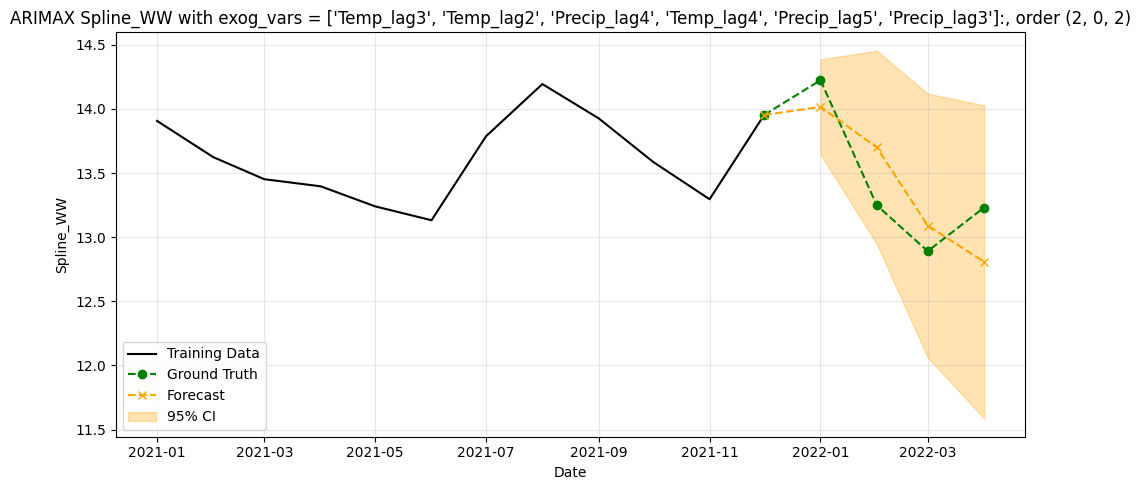

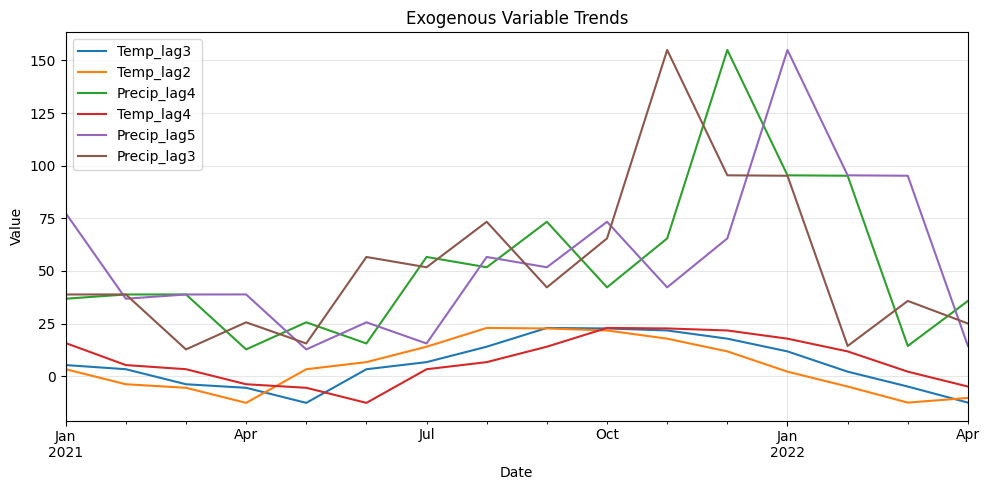


MODEL SUMMARY
RMSE: 0.3415
AIC: 26.0275


In [ ]:
model, forecast, results = plot_arimax_results(
    df=df_lagged,
    target_col='Spline_WW',
    exog_cols=selected_lags_colnames_spline_ww,
    title_prefix=f"ARIMAX Spline_WW with exog_vars = {selected_lags_colnames_spline_ww}",
    auto=True
)

# Access results
print(f"RMSE: {results['metrics']['rmse']:.4f}")
print(f"AIC: {results['metrics']['aic']:.4f}")

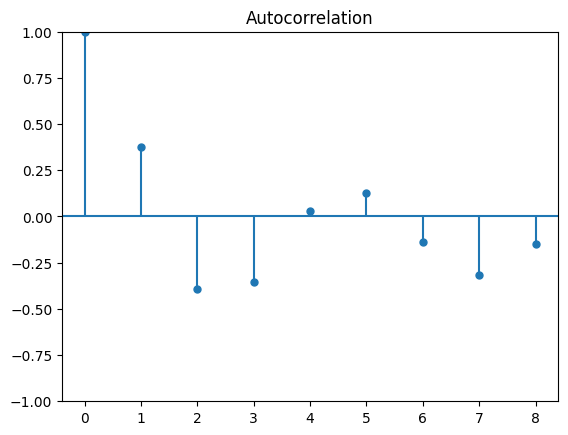

p_val 0.7375761474947947, should_diff True


In [ ]:
y = df_lagged['Spline_WW']
pm.plot_acf(df_lagged['Spline_WW'])

from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(y)

print(f'p_val {p_val}, should_diff {should_diff}')

### Top 4 Most Optimal Lags (manual)

In [ ]:
selected_lags = optimal_lags_spline_ww[:4]
selected_lags_colnames_spline_ww = [col for col, corr in selected_lags]
print(selected_lags_colnames_spline_ww)

selected_lags_colnames_spline_ww =['Temp_lag2', 'Precip_lag3']

['Temp_lag3', 'Temp_lag2', 'Precip_lag4', 'Temp_lag4']


Training samples: 12
Test samples: 4
AIC: 10.920433050946361 | BIC: 14.314779599462362


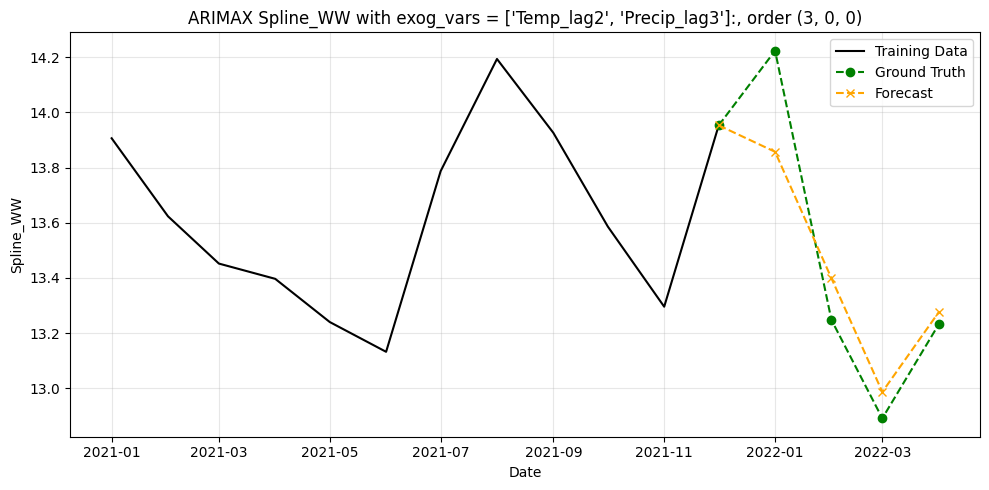

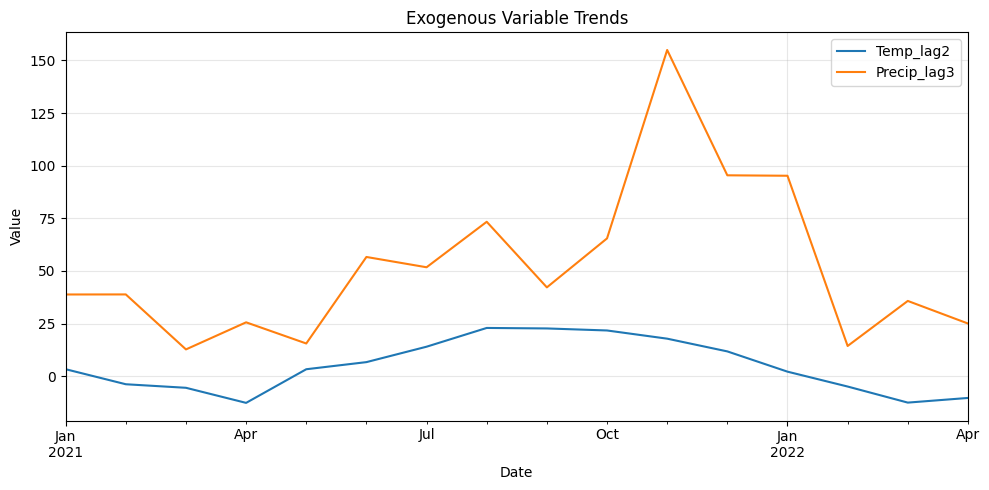


MODEL SUMMARY


AttributeError: 'ARIMA' object has no attribute 'aic'

In [ ]:
model, forecast, results = plot_arimax_results(
    df=df_lagged,
    target_col='Spline_WW',
    exog_cols=selected_lags_colnames_spline_ww,
    title_prefix=f"ARIMAX Spline_WW with exog_vars = {selected_lags_colnames_spline_ww}",
    auto=False,
    order=(3, 0, 0)
)

# Access results
print(f"RMSE: {results['metrics']['rmse']:.4f}")
print(f"AIC: {results['metrics']['aic']:.4f}")

In [ ]:
model, forecast, results = plot_arimax_results(
        df_lagged,
        target_col = 'Spline_WW',
        exog_cols = , train_size=None,
                       figsize=(15, 12), title_prefix="ARIMAX Model"):

In [ ]:
# Choose # Of Optimal Lags to Include

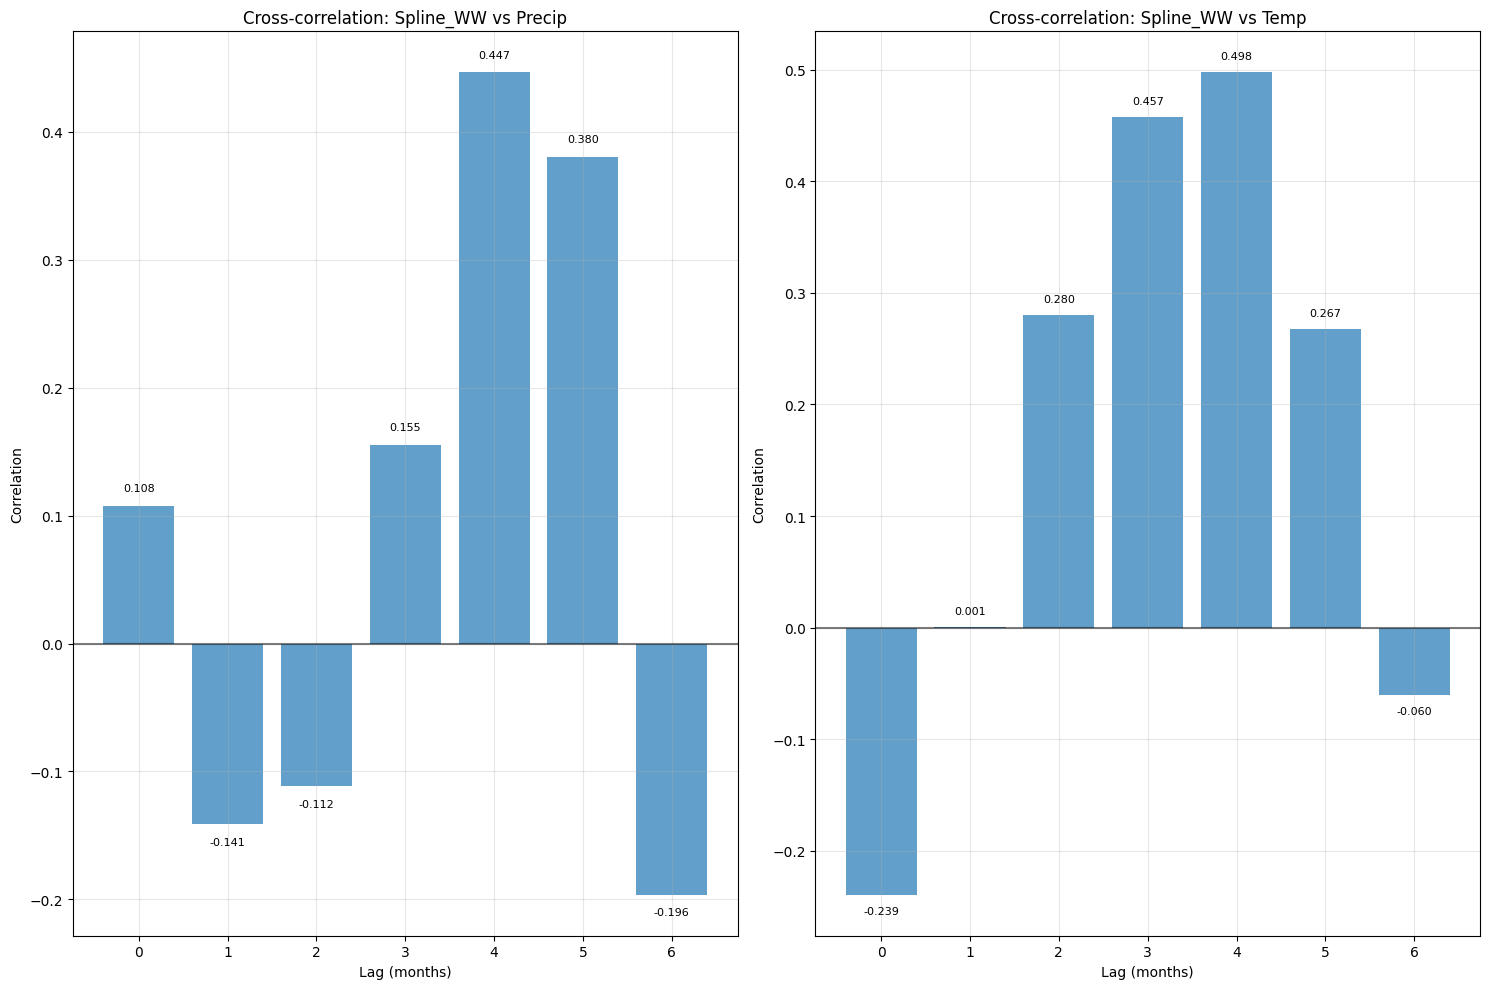

In [ ]:

# Lag analysis
correlations = plot_lag_analysis(
    df=df,
    target_col='Spline_WW',
    weather_vars=['Precip', 'Temp'],
    max_lags=6
)

### Find all combinations of Top 10 lags

In [ ]:
print(optimal_lags)

[('Temp_lag3', 0.5731770714236406), ('Temp_lag2', 0.5405614356461996), ('Precip_lag4', 0.526849833837592), ('Temp_lag4', 0.5157342272553844), ('Precip_lag5', 0.341593741672195), ('Precip_lag3', 0.3252135750557189), ('Temp_lag1', 0.32027735748331965), ('Precip_lag0', 0.29650506178478697), ('Temp_lag5', 0.22800857109150213), ('Precip_lag1', 0.1163557475015589), ('Precip_lag2', 0.10966288699116661), ('Temp_lag0', -0.020566769815821728), ('Temp_lag6', -0.059939501586589915), ('Precip_lag6', -0.19625039518678317)]


In [ ]:
correlation_combinations_spline_ww = get_all_combinations([col for col, _ in optimal_lags[:8]])

In [ ]:
spline_ww_combinations_results = []
for combination in correlation_combinations_spline_ww:
    print(combination)
    model, forecast, results = plot_arimax_results(
        df=df_lagged,
        target_col='Spline_WW',
        exog_cols=combination,
        title_prefix=f"ARIMAX Spline_WW with exog_vars = {combination}",
        auto=True
    )

    # Access results
    print(f"RMSE: {results['metrics']['rmse']:.4f}")
    print(f"AIC: {results['metrics']['aic']:.4f}")

    spline_ww_combinations_results.append((combination, results))


Output hidden; open in https://colab.research.google.com to view.

### Rank Results

In [ ]:
sorted_results = sorted(spline_ww_combinations_results, key=lambda x: x[1]['metrics']['rmse'])
for exogs, result in sorted_results:
    print(f"Exog Vars: {exogs}, RMSE: {result['metrics']['rmse']:.4f}")


Exog Vars: ['Temp_lag3', 'Temp_lag2'], RMSE: 0.2478
Exog Vars: ['Precip_lag4', 'Temp_lag4', 'Precip_lag5', 'Temp_lag1', 'Precip_lag0'], RMSE: 0.2577
Exog Vars: ['Temp_lag2', 'Precip_lag3'], RMSE: 0.2656
Exog Vars: ['Precip_lag4', 'Temp_lag4', 'Precip_lag5', 'Temp_lag1'], RMSE: 0.2778
Exog Vars: ['Temp_lag3', 'Precip_lag4', 'Temp_lag4', 'Precip_lag5', 'Temp_lag1'], RMSE: 0.3170
Exog Vars: ['Precip_lag4', 'Precip_lag5', 'Temp_lag1'], RMSE: 0.3199
Exog Vars: ['Temp_lag3', 'Precip_lag4', 'Temp_lag4', 'Precip_lag0'], RMSE: 0.3255
Exog Vars: ['Temp_lag2', 'Precip_lag4', 'Temp_lag4', 'Precip_lag5', 'Precip_lag3', 'Precip_lag0'], RMSE: 0.3348
Exog Vars: ['Temp_lag3', 'Temp_lag2', 'Precip_lag3'], RMSE: 0.3395
Exog Vars: ['Temp_lag3', 'Temp_lag2', 'Precip_lag4', 'Temp_lag4', 'Precip_lag5', 'Precip_lag3'], RMSE: 0.3415
Exog Vars: ['Temp_lag3', 'Precip_lag3', 'Temp_lag1'], RMSE: 0.3533
Exog Vars: ['Temp_lag3', 'Temp_lag4', 'Precip_lag0'], RMSE: 0.3552
Exog Vars: ['Temp_lag3', 'Precip_lag4', 'Preci

### Others

In [ ]:
main_analysis(df)

=== ARIMAX Model Analysis for COVID-Weather Relationships ===
Training samples: 10
Testing samples: 6

=== Stationarity Tests for Spline_WW ===
ADF Test:
  Test Statistic: -1.8222
  p-value: 0.3695
  Critical Values: {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}
KPSS Test:
  Test Statistic: 0.1479
  p-value: 0.1000
  Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  → Results are MIXED - further investigation needed

=== Stationarity Tests for Spline_WW_diff ===
ADF Test:
  Test Statistic: -2.4363
  p-value: 0.1318
  Critical Values: {'1%': -4.9386902332361515, '5%': -3.477582857142857, '10%': -2.8438679591836733}
KPSS Test:
  Test Statistic: 0.1298
  p-value: 0.1000
  Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  → Results are MIXED - further investigation needed

=== Lag Selection Analysis ===
Cross-correlations (absolute values):
  Temp_lag6: 0.6972
  Temp_lag5: 0.6835
  Precip_lag6: 0.6264
  Te

({'name': 'Auto ARIMA - All 1-month Lags',
  'model': ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True),
  'forecast': 2021-11-01    0.272825
  2021-12-01   -0.235850
  2022-01-01   -0.379033
  2022-02-01   -0.138044
  2022-03-01   -0.234562
  Freq: MS, dtype: float64,
  'mse': 0.22780767210000485,
  'mae': 0.456347980776959,
  'rmse': 0.47729201973216023,
  'aic': -3.150630643181721,
  'bic': -2.1645077565006225,
  'order': (0, 0, 1),
  'exog_vars': ['Precip_lag1', 'Temp_lag1'],
  'n_train': 9,
  'n_test': 5},
 [{'name': 'Auto ARIMA - Current Weather',
   'model': ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
         with_intercept=False),
   'forecast': 2021-11-01   -0.222686
   2021-12-01   -0.169743
   2022-01-01   -0.119073
   2022-02-01   -0.077837
   2022-03-01   -0.054290
   Freq: MS, dtype: float64,
   'mse': 0.38724556349702033,
   'mae': 0.5702080348017258,
   'rmse': 0.6222905780236596,
   'aic': 9.053390128718315,
   'bic': 9.84228843806319

In [ ]:
# Your current approach with improvements:
import pmdarima as pm

# Create lagged features first
df_with_lags = create_lagged_features(df, ['Precip', 'Temp'], max_lags=6)

# Test different lag combinations
lag_combinations = [
    ['Temp_lag1', 'Precip_lag1'],  # 1-month lag
    ['Temp_lag2', 'Precip_lag2'],  # 2-month lag
    ['Temp_lag1', 'Temp_lag2', 'Precip_lag1'],  # Mixed lags
    ['Temp', 'Temp_lag1', 'Precip_lag1'],  # Current + lagged
]

best_aic = float('inf')
best_model = None

for exog_vars in lag_combinations:
    model = pm.auto_arima(
        df_with_lags['Spline_WW'].dropna(),
        X=df_with_lags[exog_vars].dropna(),
        seasonal=False,  # Monthly data may need seasonal=True
        stepwise=True,
        suppress_warnings=True,
        max_p=3, max_q=3, max_d=2
    )

    if model.aic() < best_aic:
        best_aic = model.aic()
        best_model = model
        best_exog = exog_vars

In [ ]:
print(best_aic, best_model, best_exog)

12.002222185849845  ARIMA(0,0,0)(0,0,0)[0] intercept ['Temp_lag2', 'Precip_lag2']


### 1.4.2.1 Find Top Lags

In [ ]:
df_lagged = create_lagged_features(df, ['Precip', 'Temp'], max_lags=6)
# print(df_lagged)

In [ ]:
optimal_lags_spline_pr = find_optimal_lags(df_lagged['Spline_PR'], df_lagged)


=== Lag Selection Analysis ===
Cross-correlations (absolute values):
  Precip_lag5: 0.6610
  Precip_lag4: 0.4867
  Temp_lag4: 0.4630
  Temp_lag5: 0.4195
  Temp_lag3: 0.3587
  Temp_lag6: 0.2336
  Precip_lag3: 0.2139
  Temp_lag2: 0.1965
  Precip_lag6: 0.0873
  Precip_lag0: 0.0082


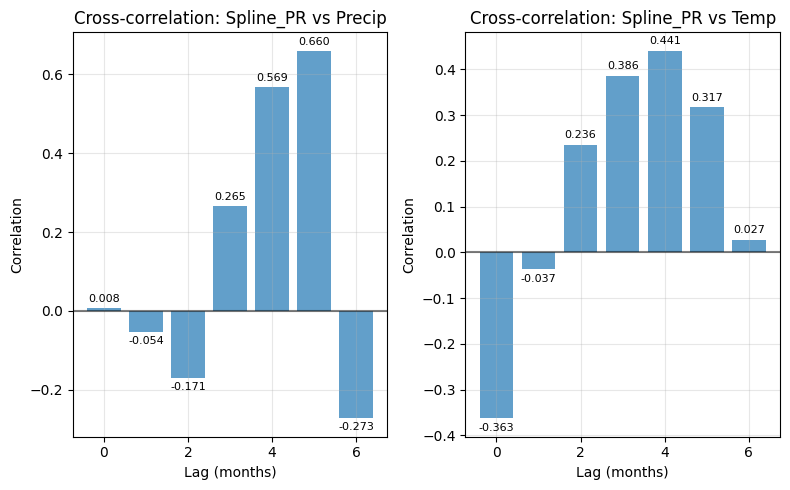

{'Precip': [0.008239536729772439,
  -0.05409797458172958,
  -0.1713933501580632,
  0.26543612622250484,
  0.56856174711,
  0.6602414016036513,
  -0.2729732018765557],
 'Temp': [-0.3626439602450107,
  -0.03673605181093559,
  0.2355299984631671,
  0.38559610383218706,
  0.44066171918795566,
  0.3168245971185914,
  0.027020804373167697]}

In [ ]:
plot_lag_analysis(df_lagged, 'Spline_PR', ['Precip', 'Temp'], max_lags=6, figsize=(8, 5))

### Top 4 Most Optimal Lags (auto arima)

In [ ]:
selected_lags_spline_pr = optimal_lags_spline_pr[:6]
selected_lags_colnames_spline_pr = [col for col, corr in selected_lags_spline_pr]
print(selected_lags_colnames_spline_pr)

selected_lags_colnames_spline_pr = ['Temp_lag4', 'Temp_lag3', 'Precip_lag3', 'Temp_lag2']

['Precip_lag5', 'Precip_lag4', 'Temp_lag4', 'Temp_lag5', 'Temp_lag3', 'Temp_lag6']


Training samples: 12
Test samples: 4
p_val 0.5302184982855958, should_diff True


Best model: ARIMA(3, 0, 1)
AIC: -27.07 | BIC: -22.22


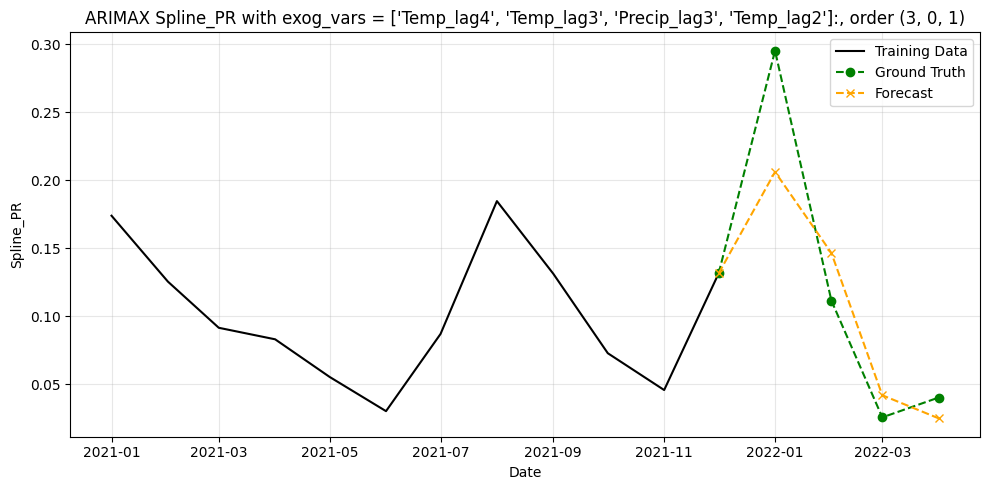

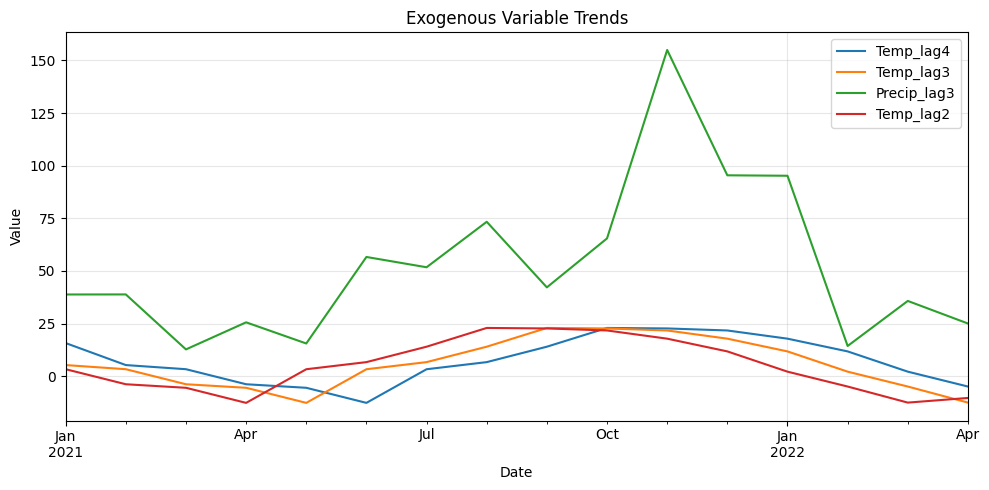


MODEL SUMMARY
RMSE: 0.0491
AIC: -27.0693


In [ ]:
model, forecast, results = plot_arimax_results(
    df=df_lagged,
    target_col='Spline_PR',
    exog_cols=selected_lags_colnames_spline_pr,
    title_prefix=f"ARIMAX Spline_PR with exog_vars = {selected_lags_colnames_spline_pr}",
    auto=True
)

# Access results
print(f"RMSE: {results['metrics']['rmse']:.4f}")
print(f"AIC: {results['metrics']['aic']:.4f}")

### Top 4 Most Optimal Lags (manual)

In [ ]:
selected_lags = optimal_lags_spline_pr[:4]
selected_lags_colnames_spline_pr = [col for col, corr in selected_lags]
print(optimal_lags_spline_pr)

selected_lags_colnames_spline_pr = ['Temp_lag4', 'Temp_lag3', 'Precip_lag3', 'Temp_lag2']

[('Precip_lag5', 0.6609727443442271), ('Precip_lag4', 0.48669812930364437), ('Temp_lag4', 0.46304378415423053), ('Temp_lag5', 0.41949817409681567), ('Temp_lag3', 0.35869479839754376), ('Temp_lag6', 0.23356285037399943), ('Precip_lag3', 0.21385631994973894), ('Temp_lag2', 0.1964738177393096), ('Precip_lag6', 0.08726912788169117), ('Precip_lag0', 0.008239536729772439), ('Temp_lag1', -0.0810838368599152), ('Precip_lag1', -0.11868758111242139), ('Precip_lag2', -0.20374566001573524), ('Temp_lag0', -0.3626439602450107)]


Training samples: 12
Test samples: 4
AIC: -29.30583612457417 | BIC: -24.456769626694168


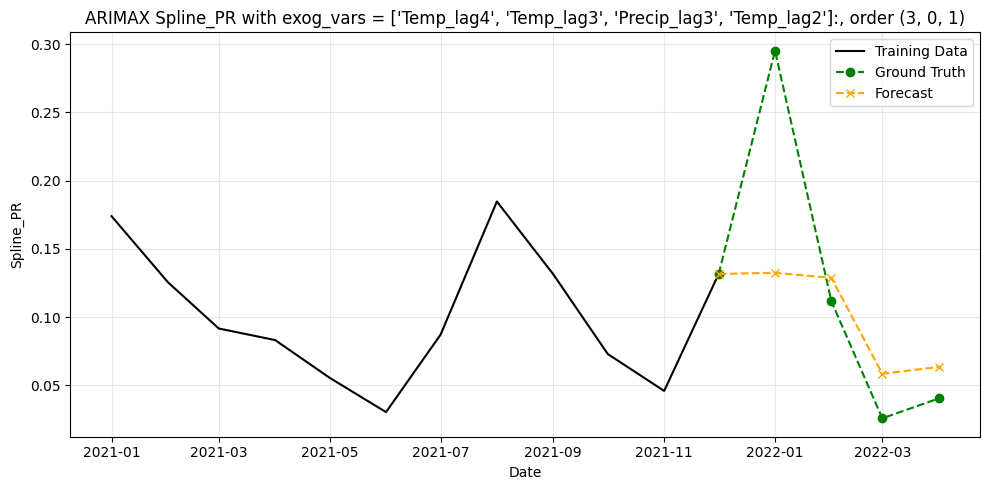

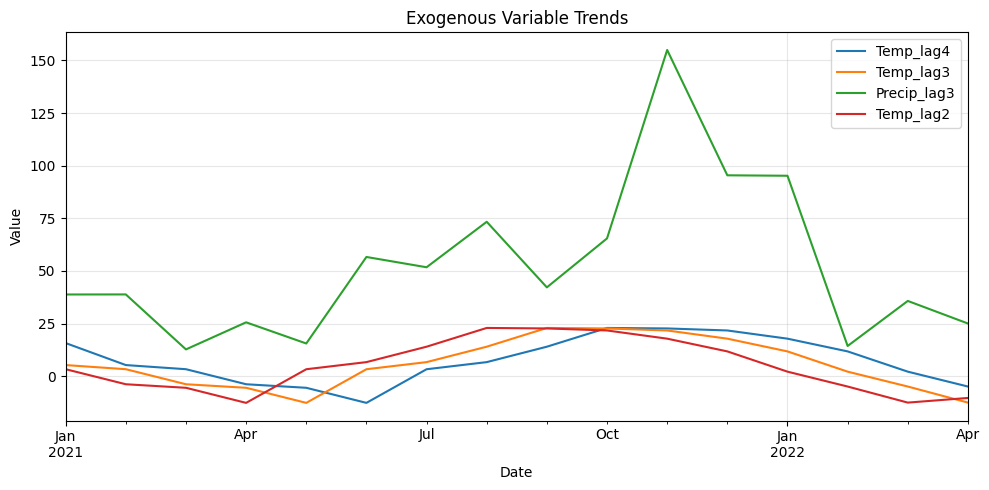


MODEL SUMMARY


AttributeError: 'ARIMA' object has no attribute 'aic'

In [ ]:
model, forecast, results = plot_arimax_results(
    df=df_lagged,
    target_col='Spline_PR',
    exog_cols=selected_lags_colnames_spline_pr,
    title_prefix=f"ARIMAX Spline_PR with exog_vars = {selected_lags_colnames_spline_pr}",
    auto=False,
    order=(3, 0, 1)
)

# Access results
print(f"RMSE: {results['metrics']['rmse']:.4f}")
print(f"AIC: {results['metrics']['aic']:.4f}")

In [ ]:
model, forecast, results = plot_arimax_results(
        df_lagged,
        target_col = 'Spline_WW',
        exog_cols = , train_size=None,
                       figsize=(15, 12), title_prefix="ARIMAX Model"):

SyntaxError: invalid syntax (ipython-input-43-1602220938.py, line 4)

In [ ]:
# Choose # Of Optimal Lags to Include

In [ ]:

# Lag analysis
correlations = plot_lag_analysis(
    df=df,
    target_col='Spline_WW',
    weather_vars=['Precip', 'Temp'],
    max_lags=6
)

### Find all combinations of Top 10 lags

In [ ]:
print(optimal_lags)

[('Precip_lag5', 0.6609727443442271), ('Precip_lag4', 0.48669812930364437), ('Temp_lag4', 0.46304378415423053), ('Temp_lag5', 0.41949817409681567), ('Temp_lag3', 0.35869479839754376), ('Temp_lag6', 0.23356285037399943), ('Precip_lag3', 0.21385631994973894), ('Temp_lag2', 0.1964738177393096), ('Precip_lag6', 0.08726912788169117), ('Precip_lag0', 0.008239536729772439), ('Temp_lag1', -0.0810838368599152), ('Precip_lag1', -0.11868758111242139), ('Precip_lag2', -0.20374566001573524), ('Temp_lag0', -0.3626439602450107)]


In [ ]:
correlation_combinations_spline_ww = get_all_combinations([col for col, _ in optimal_lags[:8]])

In [ ]:
spline_ww_combinations_results = []
for combination in correlation_combinations_spline_ww:
    print(combination)
    model, forecast, results = plot_arimax_results(
        df=df_lagged,
        target_col='Spline_PR',
        exog_cols=combination,
        title_prefix=f"ARIMAX Spline_PR with exog_vars = {combination}",
        auto=True
    )

    # Access results
    print(f"RMSE: {results['metrics']['rmse']:.4f}")
    print(f"AIC: {results['metrics']['aic']:.4f}")

    spline_ww_combinations_results.append((combination, results))


Output hidden; open in https://colab.research.google.com to view.

### Rank Results

In [ ]:
sorted_results = sorted(spline_ww_combinations_results, key=lambda x: x[1]['metrics']['rmse'])
for exogs, result in sorted_results:
    print(f"Exog Vars: {exogs}, RMSE: {result['metrics']['rmse']:.4f}")


Exog Vars: ['Temp_lag4', 'Temp_lag3', 'Precip_lag3', 'Temp_lag2'], RMSE: 0.0491
Exog Vars: ['Temp_lag4', 'Temp_lag5', 'Temp_lag2'], RMSE: 0.0529
Exog Vars: ['Temp_lag5', 'Temp_lag3', 'Temp_lag6', 'Temp_lag2'], RMSE: 0.0542
Exog Vars: ['Temp_lag5', 'Temp_lag3', 'Temp_lag2'], RMSE: 0.0560
Exog Vars: ['Precip_lag4', 'Temp_lag5', 'Temp_lag2'], RMSE: 0.0581
Exog Vars: ['Temp_lag5', 'Temp_lag6', 'Temp_lag2'], RMSE: 0.0594
Exog Vars: ['Precip_lag5', 'Temp_lag4', 'Temp_lag3', 'Temp_lag2'], RMSE: 0.0596
Exog Vars: ['Temp_lag5', 'Temp_lag6'], RMSE: 0.0603
Exog Vars: ['Precip_lag5', 'Precip_lag4', 'Temp_lag6'], RMSE: 0.0605
Exog Vars: ['Temp_lag5', 'Temp_lag2'], RMSE: 0.0609
Exog Vars: ['Temp_lag5'], RMSE: 0.0644
Exog Vars: ['Precip_lag5'], RMSE: 0.0644
Exog Vars: ['Precip_lag5', 'Temp_lag4', 'Temp_lag6', 'Temp_lag2'], RMSE: 0.0651
Exog Vars: ['Temp_lag4', 'Temp_lag5', 'Temp_lag6', 'Temp_lag2'], RMSE: 0.0659
Exog Vars: ['Temp_lag4', 'Temp_lag5', 'Temp_lag3', 'Temp_lag6'], RMSE: 0.0674
Exog Vars: 

# 1.5 ARIMAX Models with ERA5 Daily Data

### Load Data

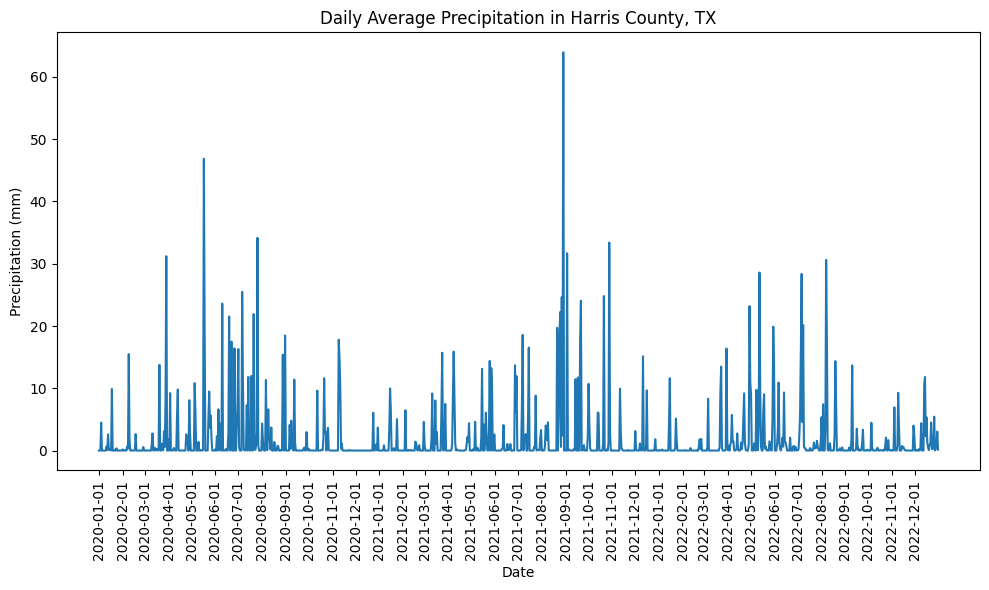

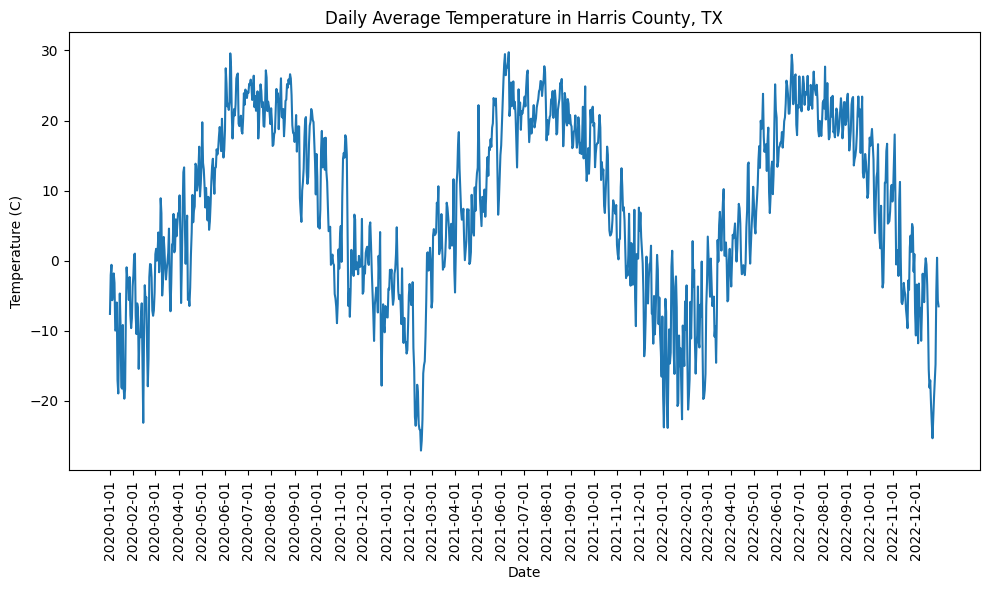

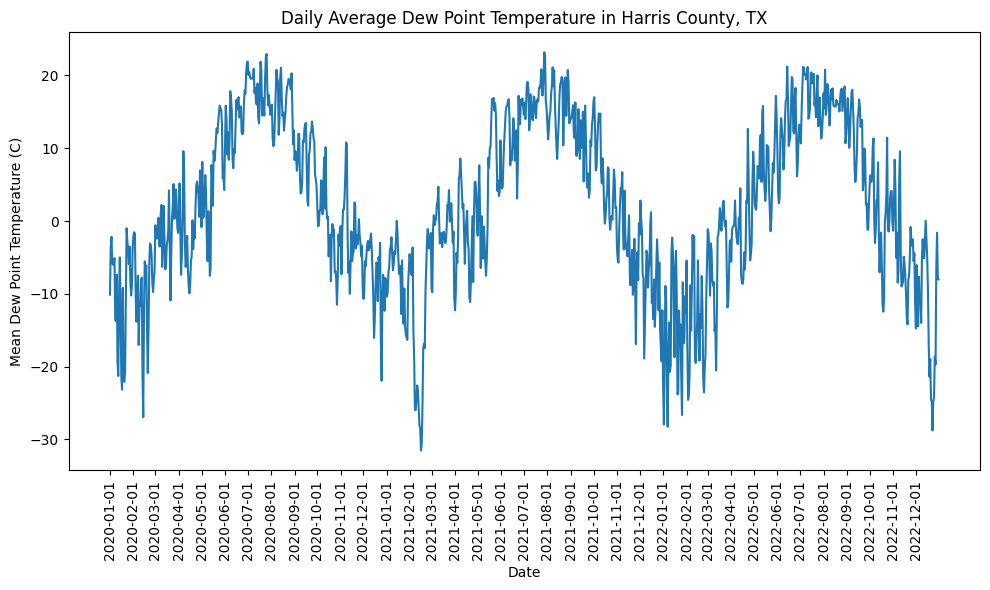

In [26]:
import matplotlib.dates as mdates

csv_folder_path = "/content/drive/Shareddrives/Wastewater/PRISM Data/Harris Data/Daily/csvs"
ppt_df = pd.read_csv(os.path.join(csv_folder_path, "daily_avg_harris_ppt.csv"), parse_dates=["Date"])
ppt_df = ppt_df[ppt_df['Date'] <= '2022-12-31']
ppt_df.set_index("Date", inplace=True)
ppt_df = ppt_df.drop(columns=["Unnamed: 0"], errors="ignore")

tmean_df = pd.read_csv(os.path.join(csv_folder_path, "daily_avg_harris_tmean.csv"), parse_dates=["Date"])
tmean_df = tmean_df[tmean_df['Date'] <= '2022-12-31']
tmean_df.set_index("Date", inplace=True)
tmean_df = tmean_df.drop(columns=["Unnamed: 0"], errors="ignore")

tdmean_df = pd.read_csv(os.path.join(csv_folder_path, "daily_avg_harris_tdmean.csv"), parse_dates=["Date"])
tdmean_df = tdmean_df[tdmean_df['Date'] <= '2022-12-31']
tdmean_df.set_index("Date", inplace=True)
tdmean_df = tdmean_df.drop(columns=["Unnamed: 0"], errors="ignore")


plt.figure(figsize=(10, 6))
plt.plot(ppt_df.index, ppt_df["Precip"])

monthly_start_dates = ppt_df.groupby([ppt_df.index.year, ppt_df.index.month]).apply(lambda x: x.index.min()).reset_index(drop=True)

plt.xticks(monthly_start_dates,rotation=90)

plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.title("Daily Average Precipitation in Harris County, TX")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(tmean_df.index, tmean_df["Tmean"])

plt.xticks(monthly_start_dates,rotation=90)

plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.title("Daily Average Temperature in Harris County, TX")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(tdmean_df.index, tdmean_df["Tdmean"])

# monthly_start_dates = tdmean_df.groupby([tdmean_df['Date'].dt.year, tdmean_df['Date'].dt.month])['Date'].min().reset_index(drop=True)

plt.xticks(monthly_start_dates,rotation=90)

plt.xlabel("Date")
plt.ylabel("Mean Dew Point Temperature (C)")
plt.title("Daily Average Dew Point Temperature in Harris County, TX")
plt.tight_layout()
plt.show()


In [27]:
ppt_df.head()

,Precip
Date,
2020-01-01,0.000000
2020-01-02,0.000000
2020-01-03,0.015377
2020-01-04,4.495223
2020-01-05,0.000000


In [28]:
df_ppt_tmean = ppt_df.join(tmean_df, how='left')
df_ppt_tmean.head()
# df_ppt_tmean_tdmean = pd.merge(df_ppt_tmean_tdmean, tdmean_df, on='Date')
df_covid_full = pd.read_csv(
    "/content/drive/Shareddrives/Wastewater/City of Houston SARS-CoV-2 Wastewater Monitoring Data/sarscov2ww_ricehhd.csv"
)

# Create 'date' column and save date in same format as ERA5 data
df_covid_full['Date'] = pd.to_datetime(df_covid_full['date'], errors='coerce')

pd.to_datetime(df_covid_full['Date'], format="%d%b%Y")

# Save total Column and drop the column name
df_covid = df_covid_full[df_covid_full['WWTP'] == 'TOTAL']
df_covid = df_covid[['Date', 'Spline_WW', 'Spline_PR']]

df_covid.set_index('Date', inplace=True)
# df_ppt_tmean.index = pd.to_datetime(df_ppt_tmean.index)

df_covid.head()
print("PRISM:", df_ppt_tmean.index.min(), "to", df_ppt_tmean.index.max())
print("COVID:", df_covid.index.min(), "to", df_covid.index.max())

# # # # # # Join weather and COVID data on date
df_all = df_ppt_tmean.join(df_covid, how='inner')

# # Keep overlap to allow data to be shifted later
# print(df_all[['Spline_WW', 'Spline_PR']].isna().sum())
# df_all.head(-20)

PRISM: 2020-01-01 00:00:00 to 2022-12-31 00:00:00
COVID: 2020-07-06 00:00:00 to 2022-04-25 00:00:00


In [29]:
df_all.head()

,Precip,Tmean,Spline_WW,Spline_PR
Date,,,,
2020-07-06,25.484806,24.851155,13.736058,0.278724
2020-07-07,11.124348,22.937932,13.695743,0.274579
2020-07-08,0.152777,24.468297,13.656342,0.271355
2020-07-09,0.039397,26.397030,13.617883,0.268453
2020-07-10,0.012595,21.907584,13.580388,0.266363


## Create Lagged DF by 120 Days
- Creates columns: Precip_lag0, Precip_lag30, Precip_lag60, Precip_lag90, Precip_lag120

In [30]:
from pmdarima.arima.stationarity import ADFTest

In [31]:
df_lagged = create_lagged_features(df_all, ['Precip', 'Tmean'], max_lags=4, interval_size=30, dropna=True)

In [32]:
# nan_counts = df_lagged.isna().sum()
# print(df.shape)
df_lagged.head()

,Precip,Tmean,Spline_WW,Spline_PR,Precip_lag0,Precip_lag30,Precip_lag60,Precip_lag90,Precip_lag120,Tmean_lag0,Tmean_lag30,Tmean_lag60,Tmean_lag90,Tmean_lag120
Date,,,,,,,,,,,,,,
2020-11-03,0.0,9.133294,13.406405,0.073256,0.0,0.026968,0.000000,0.000000,25.484806,9.133294,4.584215,15.565275,18.048862,24.851155
2020-11-04,0.0,14.560885,13.412280,0.073738,0.0,0.049611,0.000000,11.334162,11.124348,14.560885,7.267634,18.566761,18.352572,22.937932
2020-11-05,0.0,15.377783,13.418391,0.075006,0.0,0.000000,4.131976,0.180036,0.152777,15.377783,15.877559,19.186578,21.441503,24.468297
2020-11-06,0.0,14.693016,13.424766,0.076283,0.0,0.000000,0.227603,0.086174,0.039397,14.693016,18.514450,19.145341,24.506616,26.397030
2020-11-07,0.0,17.898003,13.431428,0.078411,0.0,0.000000,4.812320,6.615729,0.012595,17.898003,13.308609,8.947584,22.709412,21.907584


In [33]:
optimal_lags_spline_ww = find_optimal_lags(df_lagged['Spline_WW'], df_lagged)


=== Lag Selection Analysis ===
Cross-correlations (absolute values):
  Tmean_lag90: 0.4739
  Tmean_lag120: 0.4455
  Tmean_lag60: 0.4194
  Tmean_lag30: 0.2396
  Precip_lag120: 0.1388
  Precip_lag0: 0.0515
  Precip_lag90: 0.0338
  Precip_lag60: 0.0332
  Precip_lag30: 0.0323
  Tmean_lag0: -0.0580


In [34]:
selected_lags_spline_ww = optimal_lags_spline_ww[:6]
selected_lags_colnames_spline_ww = [col for col, corr in selected_lags_spline_ww]
print(selected_lags_colnames_spline_ww)


['Tmean_lag90', 'Tmean_lag120', 'Tmean_lag60', 'Tmean_lag30', 'Precip_lag120', 'Precip_lag0']


In [37]:
correlation_combinations_spline_ww = get_all_combinations([col for col, _ in optimal_lags_spline_ww[:5]])
correlation_combinations_spline_ww.reverse()

In [38]:
spline_ww_combinations_results = []
for combination in correlation_combinations_spline_ww:
    print(combination)
    model, forecast, results = plot_arimax_results(
        df=df_lagged,
        target_col='Spline_WW',
        exog_cols=combination,
        title_prefix=f"ARIMAX Spline_WW with exog_vars = {combination}",
        auto=True
    )

    # Access results
    print(f"RMSE: {results['metrics']['rmse']:.4f}")
    print(f"AIC: {results['metrics']['aic']:.4f}")

    spline_ww_combinations_results.append((combination, results))


Output hidden; open in https://colab.research.google.com to view.

In [39]:
sorted_results = sorted(spline_ww_combinations_results, key=lambda x: x[1]['metrics']['rmse'])
for exogs, result in sorted_results:
    print(f"Exog Vars: {exogs}, RMSE: {result['metrics']['rmse']:.4f}")


Exog Vars: ['Tmean_lag90'], RMSE: 0.4238
Exog Vars: ['Tmean_lag60', 'Tmean_lag30'], RMSE: 0.4717
Exog Vars: ['Tmean_lag120', 'Tmean_lag30'], RMSE: 0.4909
Exog Vars: ['Tmean_lag120'], RMSE: 0.4968
Exog Vars: ['Tmean_lag120', 'Precip_lag120'], RMSE: 0.5093
Exog Vars: ['Tmean_lag90', 'Precip_lag120'], RMSE: 0.5240
Exog Vars: ['Tmean_lag60'], RMSE: 0.5298
Exog Vars: ['Tmean_lag120', 'Tmean_lag60', 'Tmean_lag30'], RMSE: 0.5320
Exog Vars: ['Tmean_lag90', 'Tmean_lag120'], RMSE: 0.5524
Exog Vars: ['Tmean_lag60', 'Precip_lag120'], RMSE: 0.5530
Exog Vars: ['Tmean_lag120', 'Tmean_lag60', 'Tmean_lag30', 'Precip_lag120'], RMSE: 0.5567
Exog Vars: ['Tmean_lag90', 'Tmean_lag120', 'Tmean_lag30'], RMSE: 0.5669
Exog Vars: ['Tmean_lag120', 'Tmean_lag60'], RMSE: 0.5816
Exog Vars: ['Tmean_lag120', 'Tmean_lag60', 'Precip_lag120'], RMSE: 0.5881
Exog Vars: ['Tmean_lag90', 'Tmean_lag60', 'Tmean_lag30', 'Precip_lag120'], RMSE: 0.5915
Exog Vars: ['Tmean_lag90', 'Tmean_lag120', 'Tmean_lag60', 'Tmean_lag30', 'Preci

Training samples: 431
Test samples: 108
p_val 0.07797182553702356, should_diff True


Best model: ARIMA(3, 0, 3)
AIC: -2940.22 | BIC: -2883.30


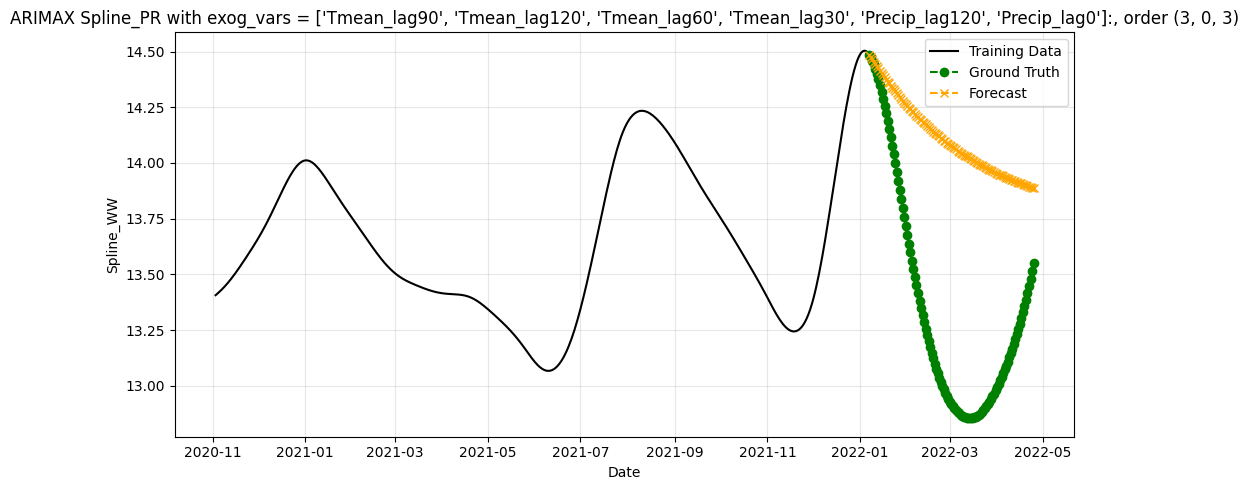

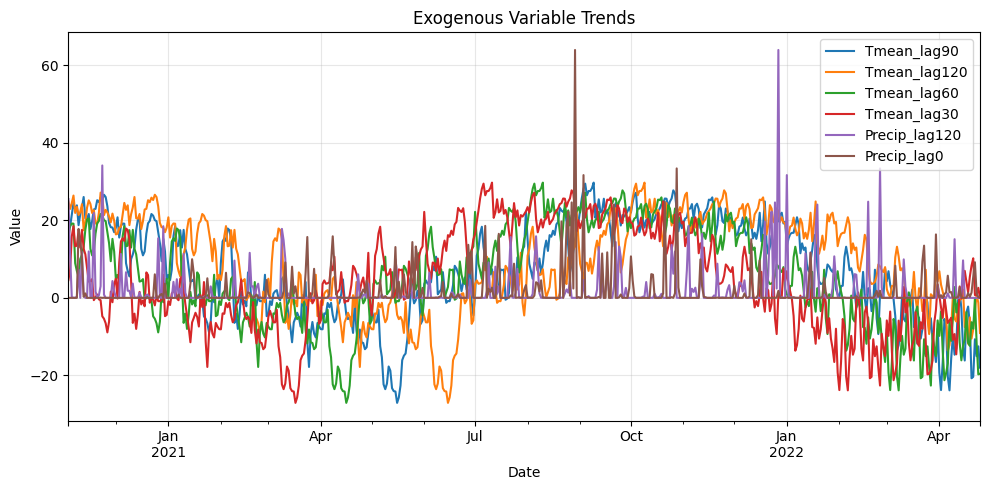


MODEL SUMMARY
RMSE: 0.8513
AIC: -2940.2238


In [ ]:
model, forecast, results = plot_arimax_results(
    df=df_lagged,
    target_col='Spline_WW',
    exog_cols=selected_lags_colnames_spline_ww,
    title_prefix=f"ARIMAX Spline_PR with exog_vars = {selected_lags_colnames_spline_ww}",
    auto=True
)

# Access results
print(f"RMSE: {results['metrics']['rmse']:.4f}")
print(f"AIC: {results['metrics']['aic']:.4f}")

In [ ]:
correlation_combinations_spline_ww = get_all_combinations([col for col, _ in optimal_lags_spline_ww[:4]])

In [ ]:
spline_ww_combinations_results = []
for combination in correlation_combinations_spline_ww:
    print(combination)
    model, forecast, results = plot_arimax_results(
        df=df_lagged,
        target_col='Spline_WW',
        exog_cols=combination,
        title_prefix=f"ARIMAX Spline_WW with exog_vars = {combination}",
        auto=True
    )

    # Access results
    print(f"RMSE: {results['metrics']['rmse']:.4f}")
    print(f"AIC: {results['metrics']['aic']:.4f}")

    spline_ww_combinations_results.append((combination, results))


Output hidden; open in https://colab.research.google.com to view.

# 1.6 (old)

### Without taking log of COVID data

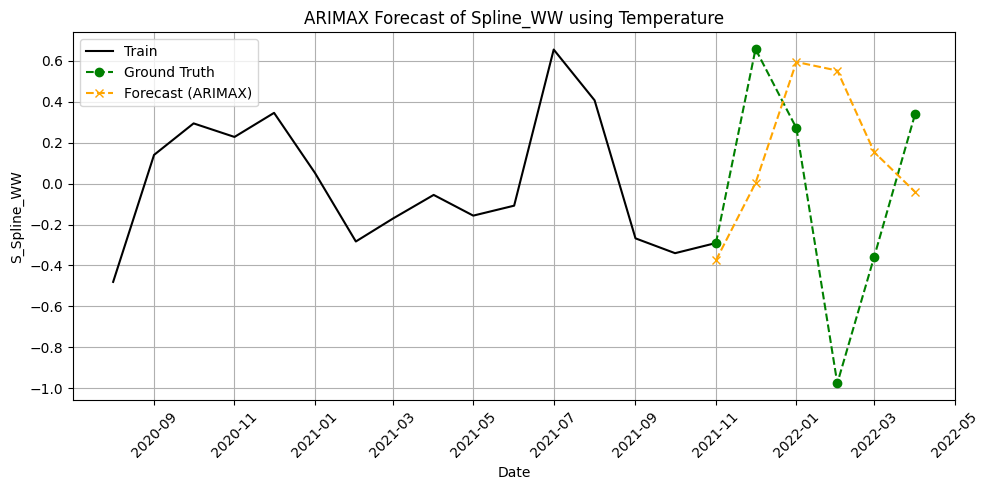

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

model = ARIMA(
    endog=df_train['S_Spline_WW'],
    exog=df_train[['temp']],
    order=(6, 1, 2)
)
model_fit = model.fit()

# Forecast using future weather
forecast = model_fit.forecast(
    steps=6,
    exog=df_test[['temp']]
)

actual = df_test['S_Spline_WW'].iloc[:6]
forecast.index = actual.index

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train['S_Spline_WW'], label='Train', color='black')
plt.plot(actual.index, actual, label='Ground Truth', color='green', linestyle='--', marker='o')
plt.plot(forecast.index, forecast, label='Forecast (ARIMAX)', color='orange', linestyle='--', marker='x')

# Add labels and grid
plt.title("ARIMAX Forecast of Spline_WW using Temperature")
plt.xlabel("Date")
plt.ylabel("S_Spline_WW")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
_, best_order, best_model_fit = arimax_grid_search(df_train['S_Spline_PR'], df_train[['temp']], df_test['S_Spline_PR'], df_test[['temp']],
                   p_values=range(0, 6), d_values=range(1, 3), q_values=range(0, 6))

Searching ARIMA(p,d,q) parameters...
ARIMA(0, 1, 0) RMSE: 0.116
ARIMA(0, 1, 1) RMSE: 0.116
ARIMA(0, 1, 2) RMSE: 0.119
ARIMA(0, 1, 3) RMSE: 0.118
ARIMA(0, 1, 4) RMSE: 0.108
ARIMA(0, 1, 5) RMSE: 0.147
ARIMA(0, 2, 0) RMSE: 0.237
ARIMA(0, 2, 1) RMSE: 0.116
ARIMA(0, 2, 2) RMSE: 0.131
ARIMA(0, 2, 3) RMSE: 0.140
ARIMA(0, 2, 4) RMSE: 0.135
ARIMA(0, 2, 5) RMSE: 0.177
ARIMA(1, 1, 0) RMSE: 0.116
ARIMA(1, 1, 1) RMSE: 0.113
ARIMA(1, 1, 2) RMSE: 0.118
ARIMA(1, 1, 3) RMSE: 0.117
ARIMA(1, 1, 4) RMSE: 0.114
ARIMA(1, 1, 5) RMSE: 0.149
ARIMA(1, 2, 0) RMSE: 0.183
ARIMA(1, 2, 1) RMSE: 0.116
ARIMA(1, 2, 2) RMSE: 0.122
ARIMA(1, 2, 3) RMSE: 0.116
ARIMA(1, 2, 4) RMSE: 0.136
ARIMA(1, 2, 5) RMSE: 0.159
ARIMA(2, 1, 0) RMSE: 0.124
ARIMA(2, 1, 1) RMSE: 0.138
ARIMA(2, 1, 2) RMSE: 0.114
ARIMA(2, 1, 3) RMSE: 0.115
ARIMA(2, 1, 4) RMSE: 0.117
ARIMA(2, 1, 5) RMSE: 0.118
ARIMA(2, 2, 0) RMSE: 0.190
ARIMA(2, 2, 1) RMSE: 0.197
ARIMA(2, 2, 2) RMSE: 0.133
ARIMA(2, 2, 3) RMSE: 0.144
ARIMA(2, 2, 4) RMSE: 0.156
ARIMA(2, 2, 5) RMS

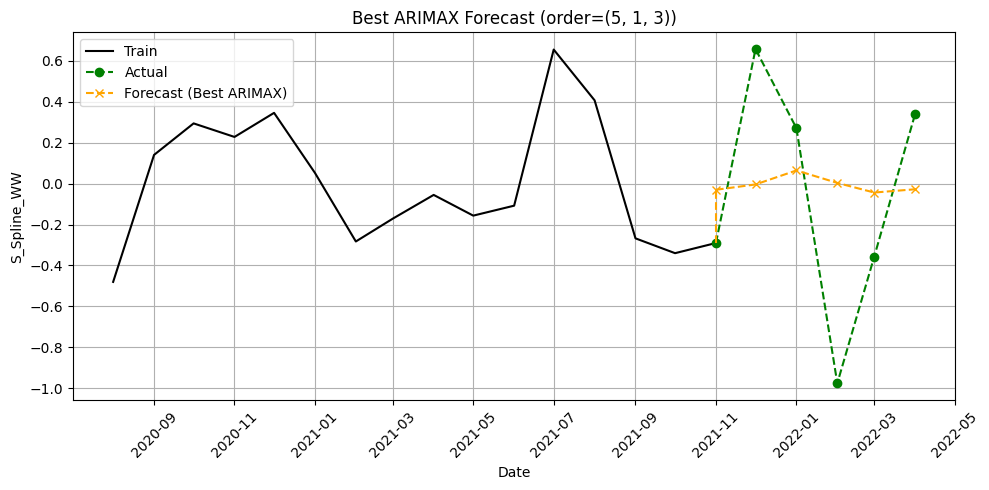


Best model coefficients:
temp      0.000362
ar.L1    -0.421102
ar.L2    -0.621560
ar.L3    -0.471350
ar.L4    -0.463758
ar.L5    -0.619619
ma.L1    -0.104059
ma.L2    -0.315798
ma.L3    -0.121416
sigma2    0.001272
dtype: float64


In [ ]:
y_train = df_train['S_Spline_WW']
exog_train = df_train[['temp']]
y_test = df_test['S_Spline_WW']
exog_test = df_test[['temp']]


# Forecast with best model
forecast_log = best_model_fit.forecast(steps=len(y_test), exog=exog_test)
forecast = np.exp(forecast_log) - 1
forecast.index = df_test.index[:len(forecast)]

# Plot result
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train['S_Spline_WW'], label='Train', color='black')
plt.plot(df_test.index, df_test['S_Spline_WW'], label='Actual', color='green', linestyle='--', marker='o')
plt.plot(forecast.index, forecast, label='Forecast (Best ARIMAX)', color='orange', linestyle='--', marker='x')
plt.plot([df_train.index[-1], forecast.index[0]],
         [df_train['S_Spline_WW'].iloc[-1], forecast.iloc[0]],
         linestyle='--', color='orange')

plt.title(f"Best ARIMAX Forecast (order={best_order})")
plt.xlabel("Date")
plt.ylabel("S_Spline_WW")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Report coefficients
print("\nBest model coefficients:")
print(best_model_fit.params)


### Taking log of COVID data

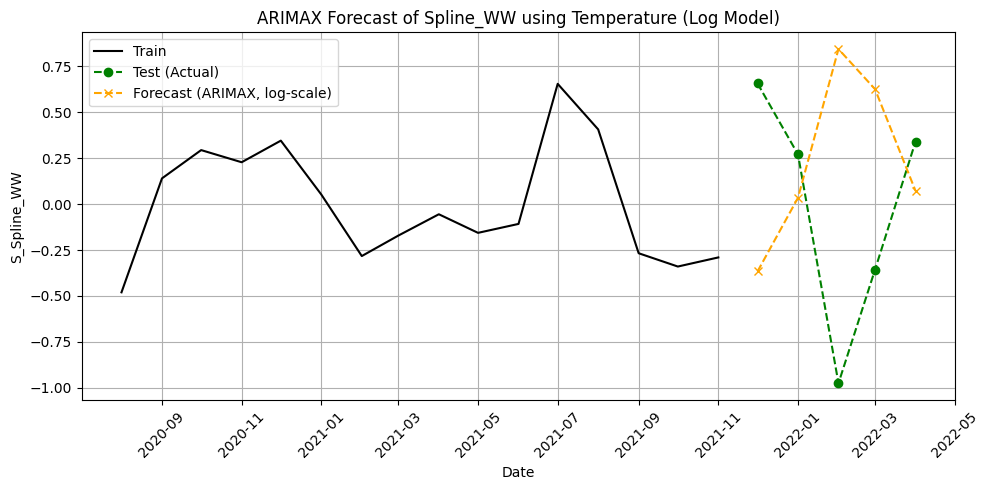


Model coefficients:
temp     -0.004982
ar.L1    -0.042728
ar.L2    -0.378506
ar.L3    -0.375574
ar.L4    -0.158510
ar.L5    -0.820121
ar.L6     0.066127
ma.L1    -0.090688
ma.L2    -0.697711
sigma2    0.020493
dtype: float64

Forecast RMSE: 1.04


In [ ]:
log Y x ARIMA terms 5  tt  0  ( )= β + β +[ ]import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# 1. Log-transform the outcome variable (COVID)
# df_train = df_covid_2nd_order_train.copy()
# df_test = df_covid_2nd_order_test.copy()

# Add a small constant to avoid log(0)
df_train['log_Spline_WW'] = np.log(df_train['S_Spline_WW'] + 1)
df_test['log_Spline_WW'] = np.log(df_test['S_Spline_WW'] + 1)

# 2. Define outcome and exogenous variables
y_train = df_train['log_Spline_WW']
exog_train = df_train[['temp']]
exog_forecast = df_test[['temp']]

# 3. Fit ARIMAX model (as in paper)
model = ARIMA(
    endog=y_train,
    exog=exog_train,
    order=(6, 1, 2)
)

model_fit = model.fit()

# 4. Forecast log outcome, then back-transform
forecast_log = model_fit.forecast(steps=5, exog=exog_forecast)
forecast = np.exp(forecast_log) - 1  # back-transform to original scale

# 5. Align forecast index
actual = df_test['S_Spline_WW']
forecast.index = actual.index

# 6. Plot forecast vs actual
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train['S_Spline_WW'], label='Train', color='black')
plt.plot(actual.index, actual, label='Test (Actual)', color='green', linestyle='--', marker='o')
plt.plot(forecast.index, forecast, label='Forecast (ARIMAX, log-scale)', color='orange', linestyle='--', marker='x')

plt.title("ARIMAX Forecast of Spline_WW using Temperature (Log Model)")
plt.xlabel("Date")
plt.ylabel("S_Spline_WW")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Print model coefficients
print("\nModel coefficients:")
print(model_fit.params)

# 8. Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, forecast))
print(f"\nForecast RMSE: {rmse:.2f}")


#### Optimizing Parameters

In [ ]:
# Log-transform outcome
df_train['log_Spline_WW'] = np.log(df_train['S_Spline_WW'] + 1)
df_test['log_Spline_WW'] = np.log(df_test['S_Spline_WW'] + 1)

y_train = df_train['log_Spline_WW']
exog_train = df_train[['temp']]
y_test = df_test['log_Spline_WW']
exog_test = df_test[['temp']]

In [ ]:
# Run grid search
sorted_orders, best_order, best_model_fit = arimax_grid_search(
    y_train, exog_train,
    y_test, exog_test,
    p_values=range(1, 7), d_values=range(0, 1), q_values=range(1, 7)
)


In [ ]:
# 3. Fit ARIMAX model (as in paper)

# P = 1, d = 1, q = 5
order=(1, 0, 5)

model = ARIMA(
    endog=y_train,
    exog=exog_train,
    order=order
)

model_fit = model.fit()

forecast = np.exp(forecast_log) - 1  # back-transform to original scale

# 5. Align forecast index
actual = df_test['S_Spline_WW']
forecast.index = actual.index


# Forecast with best model
forecast_log = model_fit.forecast(steps=len(y_test), exog=exog_test)
forecast = np.exp(forecast_log) - 1
forecast.index = df_test.index[:len(forecast)]

print(f"Training index {df_train.index}")
print(f"Test index {df_test.index}")
print(f"forecast index {forecast.index}")
# Plot result
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train['S_Spline_WW'], label='Train', color='black')
plt.plot(df_test.index, df_test['S_Spline_WW'], label='Ground Truth', color='green', linestyle='--', marker='o')
plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='--', marker='x')
plt.plot([df_train.index[-1], forecast.index[0]],
         [df_train['S_Spline_WW'].iloc[-1], forecast.iloc[0]],
         linestyle='--', color='orange')

plt.title(f"Best ARIMAX Forecast (order={order})")
plt.xlabel("Date")
plt.ylabel("S_Spline_WW")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Report coefficients
print("\nBest model coefficients:")
print(model_fit.params)


In [ ]:
for i in range(len(sorted_orders)):
    print(f"{i}. ARIMA{sorted_orders[i][0]} RMSE: {sorted_orders[i][1]:.3f}")

In [ ]:
def arimax_grid_search_multiexog(y_train, exog_train, y_test, exog_test,
                                  p_values=range(0, 4), d_values=[1], q_values=range(0, 4)):
    import warnings
    warnings.filterwarnings("ignore")

    best_score = float("inf")
    best_order = None
    best_model = None

    print("Searching ARIMA(p,d,q) parameters with multiple exogenous variables...")

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(endog=y_train, exog=exog_train, order=order)
                    model_fit = model.fit()
                    forecast_log = model_fit.forecast(steps=len(y_test), exog=exog_test)
                    forecast = np.exp(forecast_log) - 1
                    rmse = np.sqrt(mean_squared_error(np.exp(y_test) - 1, forecast))

                    print(f"ARIMA{order} RMSE: {rmse:.3f}")

                    if rmse < best_score:
                        best_score = rmse
                        best_order = order
                        best_model = model_fit
                except Exception as e:
                    print(f"ARIMA{order} failed: {e}")
                    continue

    print("\nBest ARIMA order:", best_order)
    print("Best RMSE:", round(best_score, 3))

    return best_order, best_model


In [ ]:
# Ensure frequency and alignment
df_train = df_covid_2nd_order_train.copy().asfreq('MS')
df_test = df_covid_2nd_order_test.copy().asfreq('MS')

# Log-transform COVID outcome
df_train['log_Spline_WW'] = np.log(df_train['S_Spline_WW'] + 1)
df_test['log_Spline_WW'] = np.log(df_test['S_Spline_WW'] + 1)

# Define targets and exogenous variables
y_train = df_train['log_Spline_WW']
y_test = df_test['log_Spline_WW']

exog_cols = ['temp', 'precip']
exog_train = df_train[exog_cols]
exog_test = df_test[exog_cols]


In [ ]:
best_order, best_model_fit = arimax_grid_search_multiexog(
    y_train, exog_train,
    y_test, exog_test,
    p_values=range(0, 7),
    d_values=[1],
    q_values=range(0, 7)
)


In [ ]:
forecast_log = best_model_fit.forecast(steps=len(y_test), exog=exog_test)
forecast = np.exp(forecast_log) - 1
forecast.index = df_test.index[:len(forecast)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train['S_Spline_WW'], label='Train', color='black')
plt.plot(df_test.index, df_test['S_Spline_WW'], label='Ground Truth', color='green', linestyle='--', marker='o')
plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='--', marker='x')
plt.plot([df_train.index[-1], forecast.index[0]],
         [df_train['S_Spline_WW'].iloc[-1], forecast.iloc[0]],
         linestyle='--', color='orange')

plt.title(f"Best ARIMAX Forecast (order={best_order}) using temp & precip")
plt.xlabel("Date")
plt.ylabel("S_Spline_WW")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Coefficients
print("\nBest model coefficients:")
print(best_model_fit.params)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

df_train = df_covid_2nd_order_train.copy()
df_test = df_covid_2nd_order_test.copy()

df_train = df_train.asfreq('MS')
df_test = df_test.asfreq('MS')

df_train['log_Spline_WW'] = np.log(df_train['S_Spline_WW'] + 1)
df_test['log_Spline_WW'] = np.log(df_test['S_Spline_WW'] + 1)

y_train = df_train['log_Spline_WW']
exog_train = df_train[['temp']]

forecast_steps = 4
exog_forecast = df_test[['temp']].iloc[:forecast_steps]
actual = df_test['S_Spline_WW'].iloc[:forecast_steps]

model = ARIMA(endog=y_train, exog=exog_train, order=(6, 1, 2))
model_fit = model.fit()

# Forecast and inverse log
forecast_log = model_fit.forecast(steps=forecast_steps, exog=exog_forecast)
forecast = np.exp(forecast_log) - 1

forecast.index = actual.index

plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train['S_Spline_WW'], label='Train', color='black')
plt.plot(actual.index, actual, label='Test (Actual)', color='green', linestyle='--', marker='o')
plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='--', marker='x')

# Visually connect last train point to first forecast
plt.plot(
    [df_train.index[-1], forecast.index[0]],
    [df_train['S_Spline_WW'].iloc[-1], forecast.iloc[0]],
    linestyle='--', color='orange'
)

plt.title("ARIMAX Forecast of Spline_WW using Temperature (Log Model)")
plt.xlabel("Date")
plt.ylabel("S_Spline_WW")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nModel coefficients:")
print(model_fit.params)

# RMSE
rmse = np.sqrt(mean_squared_error(actual, forecast))
print(f"\nForecast RMSE: {rmse:.2f}")


## Single Variable ARIMA

In [ ]:
df_precip = df_all[['precip']].copy()
# model = VAR(df_var)
precip_arima = ARIMA(df_precip, order=(0, 0, 0))
precip_model_fit = precip_arima.fit()
print(precip_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 precip   No. Observations:                   21
Model:                          ARIMA   Log Likelihood                -104.020
Date:                Wed, 02 Jul 2025   AIC                            212.040
Time:                        14:43:03   BIC                            214.129
Sample:                    08-01-2020   HQIC                           212.493
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.3338      9.654      5.317      0.000      32.413      70.255
sigma2      1174.8434    346.491      3.391      0.001     495.734    1853.952
Ljung-Box (L1) (Q):                   4.31   Jarque-

In [ ]:
print(df_precip)

                precip
2020-08-01   77.504745
2020-09-01   36.801460
2020-10-01   38.813759
2020-11-01   38.840454
2020-12-01   12.728225
2021-01-01   25.592295
2021-02-01   15.540181
2021-03-01   56.632133
2021-04-01   51.741447
2021-05-01   73.344475
2021-06-01   42.194492
2021-07-01   65.448158
2021-08-01  154.943832
2021-09-01   95.417274
2021-10-01   95.207138
2021-11-01   14.356248
2021-12-01   35.750870
2022-01-01   25.028669
2022-02-01    5.591195
2022-03-01   50.008289
2022-04-01   66.525467


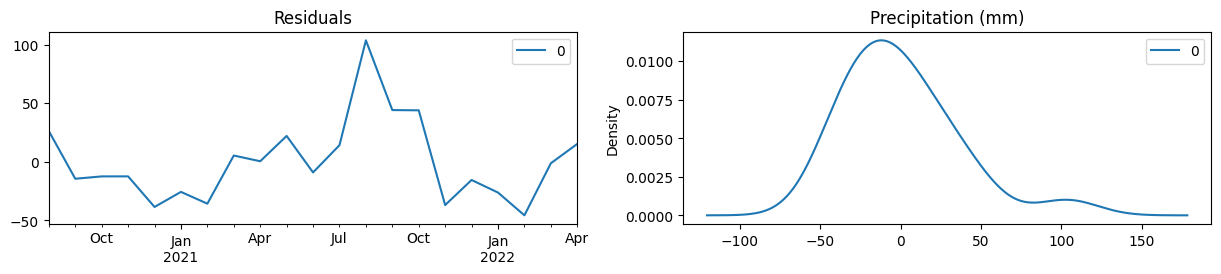

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(precip_model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,2.5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Precipitation (mm)', ax=ax[1])
plt.show()

NameError: name 'df' is not defined

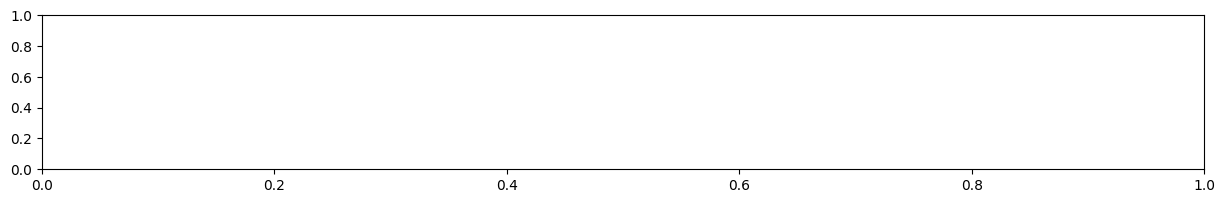

In [ ]:
# Actual vs Fitted
fig, ax = plt.subplots(figsize=(15,2))
ax = df.plot(ax=ax)
fig = precip_model_fit.predict(start=0, end=5, dynamic=True, ax=ax, plot_insample=False)
plt.show()